# Generative models

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Setup

In [100]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
!nvidia-smi

Tue May 13 01:35:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:1C:00.0  On |                  N/A |
|  0%   48C    P8             18W /  130W |    5401MiB /   6144MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [102]:
import torch

Select the device to use

In [103]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare the dataset and dataloaders

In [104]:
from torchvision import transforms

# train_mean = [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
# train_std = [0.2762017846107483, 0.2654302418231964, 0.2686000168323517]

train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]


class ContrastStretch(object):
    def __call__(self, img):
        # img: Tensor [C,H,W] in [0,1]
        lo, hi = img.min(), img.max()
        return (img - lo) / (hi - lo + 1e-5)

transform = transforms.Compose([
    transforms.ToTensor(),
    ContrastStretch(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

In [105]:
from torchvision.datasets import ImageFolder

train_dir = "./data/train"
train_ds = ImageFolder(train_dir, transform=transform)

num_classes = len(train_ds.classes)

print(f"Number of train images: {len(train_ds)}")
print(f"Number of train classes: {num_classes}")

Number of train images: 31367
Number of train classes: 43


In [106]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# VAE

## Create model

In [107]:
from gnn import ConditionalVariationalAutoencoder as cVAE
from gnn import cVAETrainer
import torch.optim as optim
import torch.nn as nn


IMG_CHANNELS = 3
latent_dim = 100

# model
cvae_model = cVAE(IMG_CHANNELS, num_classes, latent_dim=latent_dim).to(device)

# optimizers
cvae_optimizer = torch.optim.Adam(cvae_model.parameters(), lr=0.0001)
cvae_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=cvae_optimizer, gamma=0.99)


cvae_trainer = cVAETrainer(
    cvae_model=cvae_model,
    optimizer=cvae_optimizer,
    num_classes=num_classes,
    scheduler=cvae_scheduler,
    latent_dim=latent_dim,
    device=device
)

## Training

Epoch 1/100: 100%|██████████| 246/246 [00:33<00:00,  7.42it/s]


Epoch 1/100: Total Loss: 721.4502, Recon Loss: 697.5182, KLD Loss: 23.9320


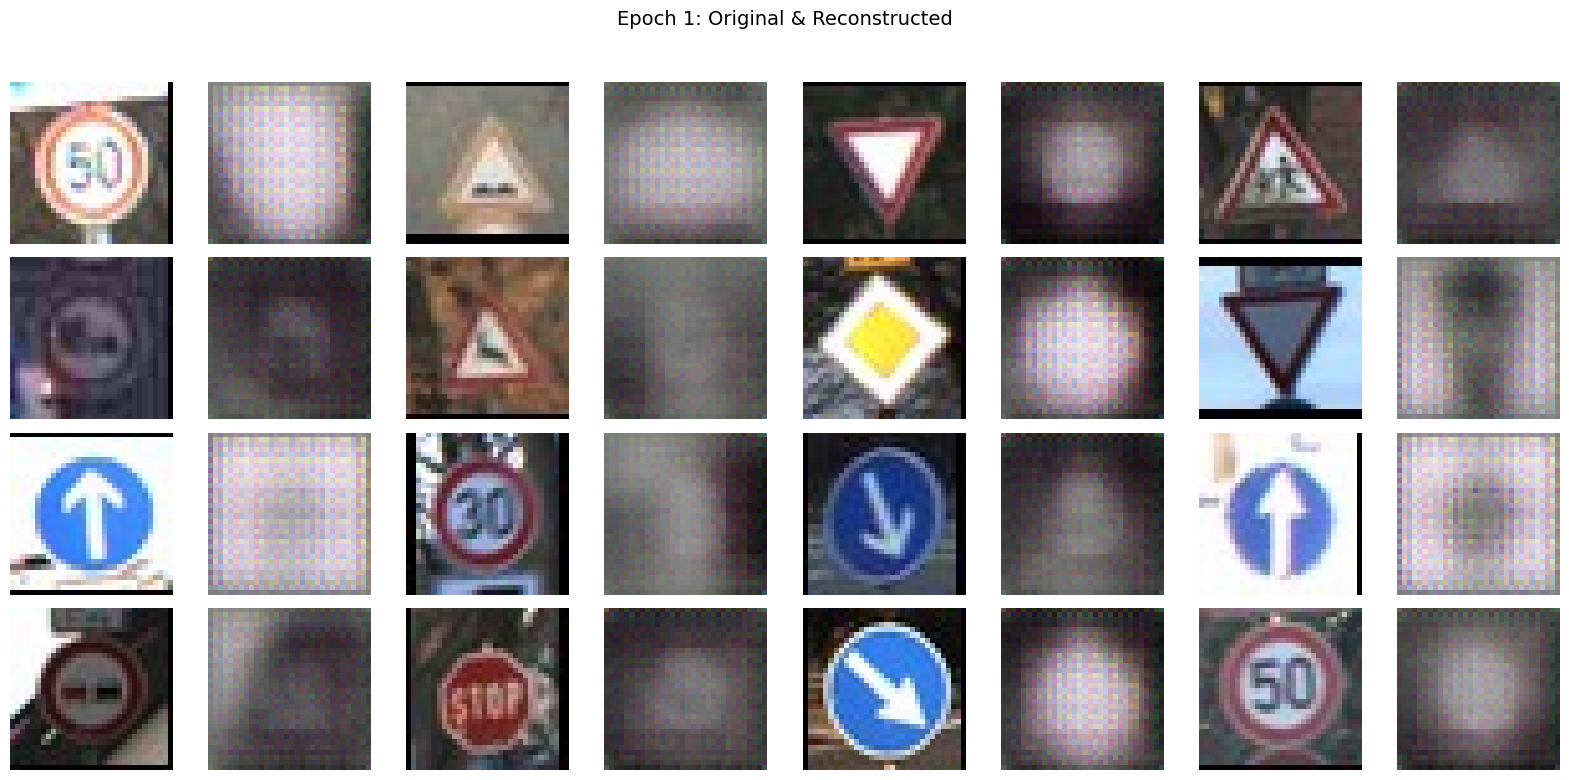

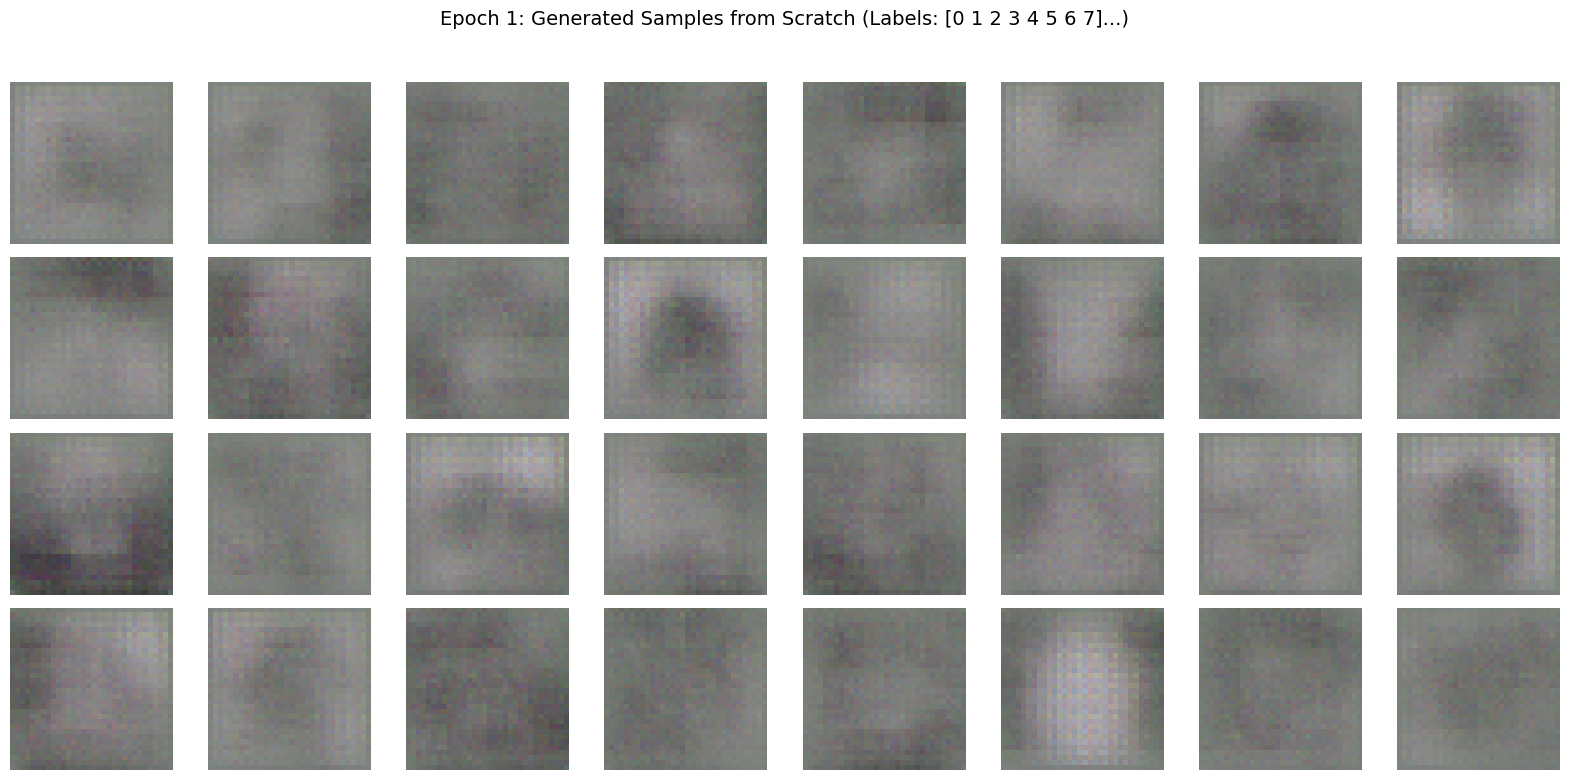

Epoch 2/100: 100%|██████████| 246/246 [00:21<00:00, 11.53it/s]


Epoch 2/100: Total Loss: 416.4216, Recon Loss: 378.3967, KLD Loss: 38.0249


Epoch 3/100: 100%|██████████| 246/246 [00:19<00:00, 12.85it/s]


Epoch 3/100: Total Loss: 351.9585, Recon Loss: 308.6509, KLD Loss: 43.3076


Epoch 4/100: 100%|██████████| 246/246 [00:23<00:00, 10.39it/s]


Epoch 4/100: Total Loss: 308.1906, Recon Loss: 262.1234, KLD Loss: 46.0672


Epoch 5/100: 100%|██████████| 246/246 [00:19<00:00, 12.49it/s]


Epoch 5/100: Total Loss: 279.3262, Recon Loss: 232.0179, KLD Loss: 47.3083


Epoch 6/100: 100%|██████████| 246/246 [00:22<00:00, 11.01it/s]


Epoch 6/100: Total Loss: 261.3319, Recon Loss: 213.8009, KLD Loss: 47.5310


Epoch 7/100: 100%|██████████| 246/246 [00:21<00:00, 11.30it/s]


Epoch 7/100: Total Loss: 247.3305, Recon Loss: 199.9847, KLD Loss: 47.3457


Epoch 8/100: 100%|██████████| 246/246 [00:18<00:00, 13.38it/s]


Epoch 8/100: Total Loss: 236.7519, Recon Loss: 189.6744, KLD Loss: 47.0775


Epoch 9/100: 100%|██████████| 246/246 [00:21<00:00, 11.26it/s]


Epoch 9/100: Total Loss: 228.0222, Recon Loss: 181.0190, KLD Loss: 47.0033


Epoch 10/100: 100%|██████████| 246/246 [00:18<00:00, 13.44it/s]


Epoch 10/100: Total Loss: 220.3101, Recon Loss: 173.2650, KLD Loss: 47.0451


Epoch 11/100: 100%|██████████| 246/246 [00:21<00:00, 11.27it/s]


Epoch 11/100: Total Loss: 214.2621, Recon Loss: 166.9597, KLD Loss: 47.3023


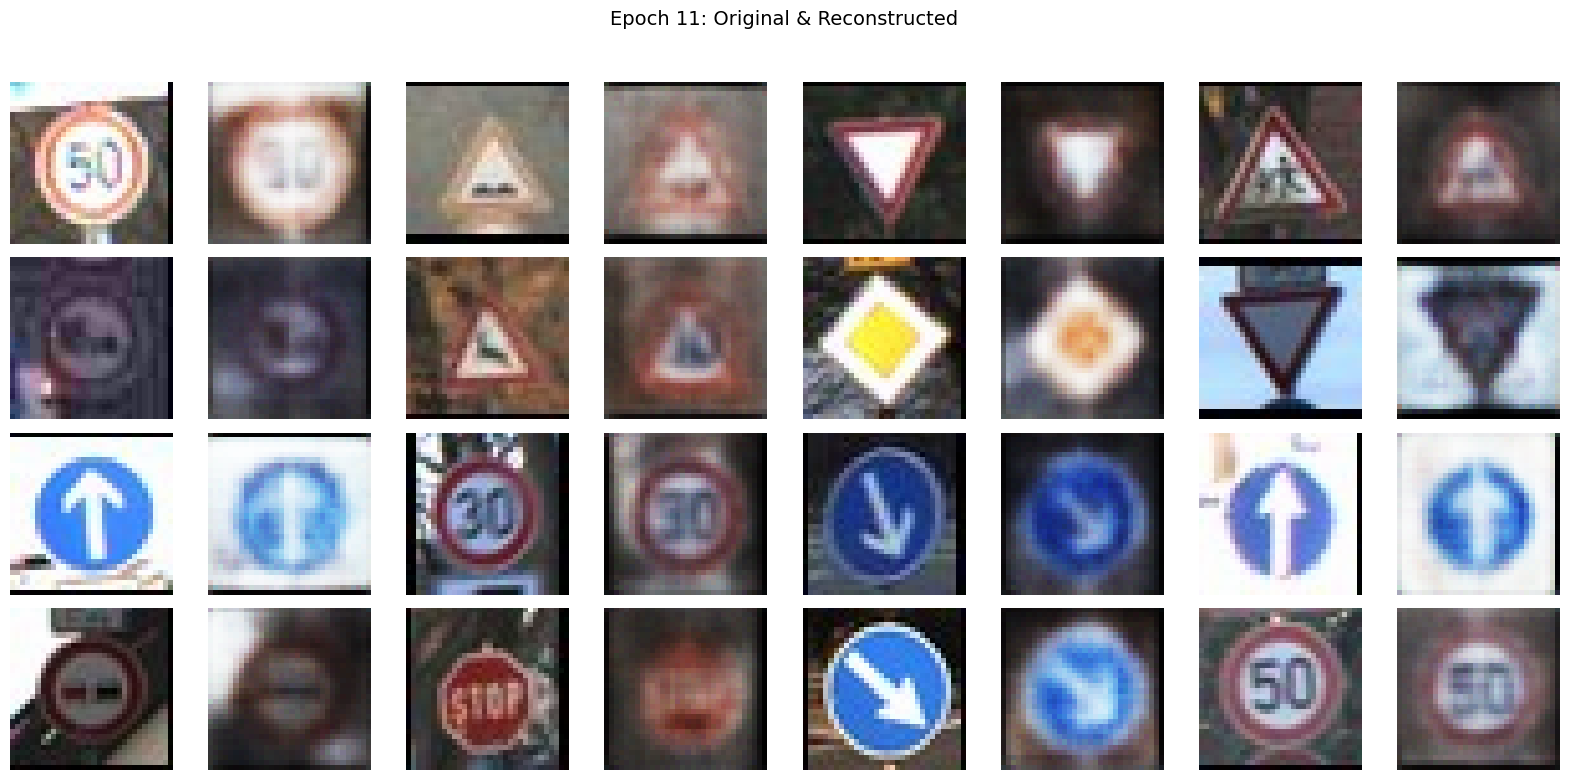

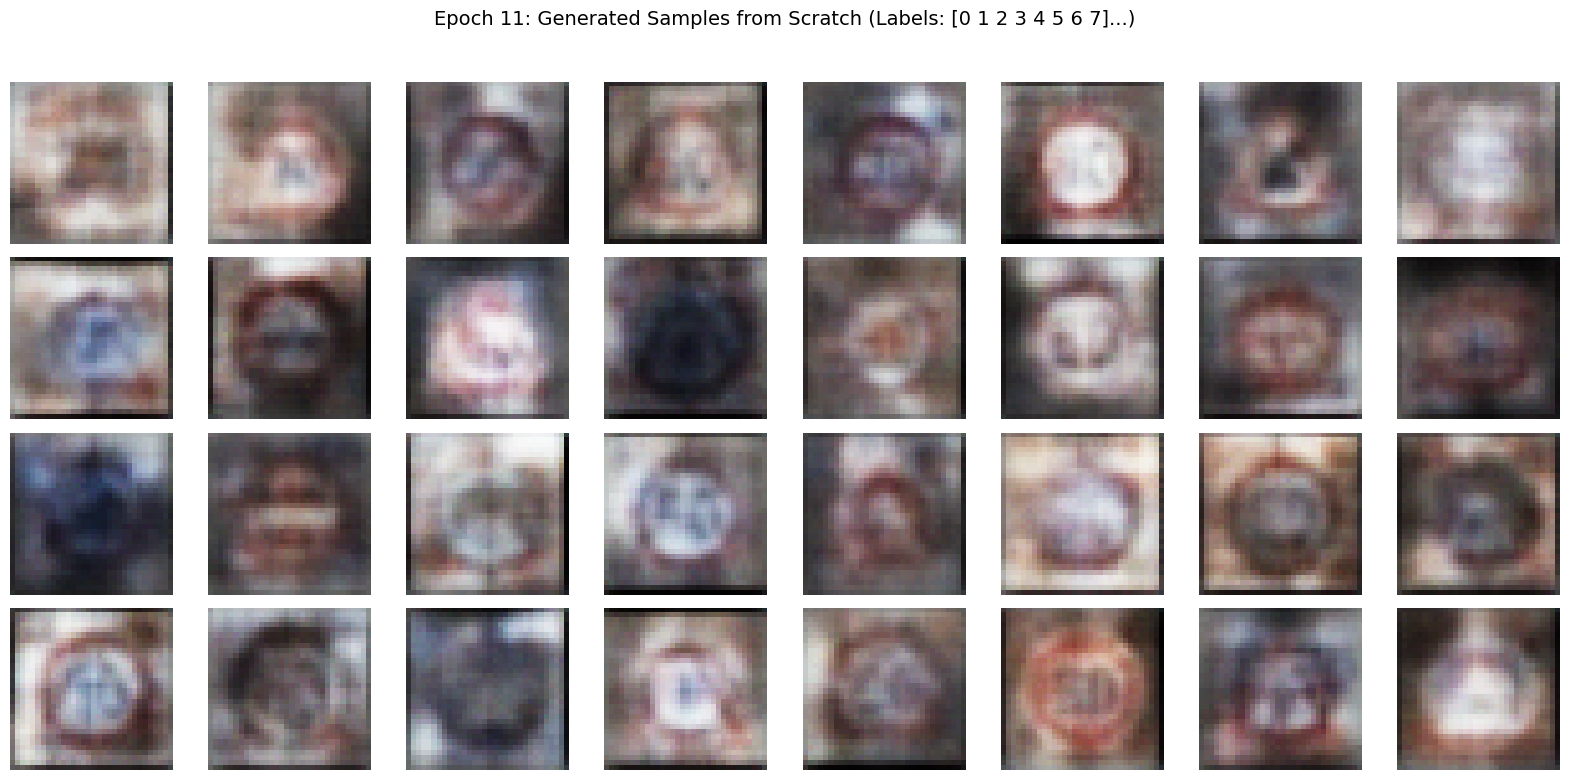

Epoch 12/100: 100%|██████████| 246/246 [00:18<00:00, 13.29it/s]


Epoch 12/100: Total Loss: 209.2454, Recon Loss: 161.7079, KLD Loss: 47.5375


Epoch 13/100: 100%|██████████| 246/246 [00:21<00:00, 11.35it/s]


Epoch 13/100: Total Loss: 204.8584, Recon Loss: 157.1422, KLD Loss: 47.7162


Epoch 14/100: 100%|██████████| 246/246 [00:22<00:00, 11.17it/s]


Epoch 14/100: Total Loss: 200.8296, Recon Loss: 152.8892, KLD Loss: 47.9404


Epoch 15/100: 100%|██████████| 246/246 [00:18<00:00, 13.18it/s]


Epoch 15/100: Total Loss: 197.7759, Recon Loss: 149.5943, KLD Loss: 48.1817


Epoch 16/100: 100%|██████████| 246/246 [00:22<00:00, 11.06it/s]


Epoch 16/100: Total Loss: 194.7157, Recon Loss: 146.3996, KLD Loss: 48.3161


Epoch 17/100: 100%|██████████| 246/246 [00:18<00:00, 13.25it/s]


Epoch 17/100: Total Loss: 191.7821, Recon Loss: 143.2264, KLD Loss: 48.5556


Epoch 18/100: 100%|██████████| 246/246 [00:22<00:00, 10.77it/s]


Epoch 18/100: Total Loss: 189.6357, Recon Loss: 140.8692, KLD Loss: 48.7665


Epoch 19/100: 100%|██████████| 246/246 [00:21<00:00, 11.28it/s]


Epoch 19/100: Total Loss: 187.5354, Recon Loss: 138.5913, KLD Loss: 48.9441


Epoch 20/100: 100%|██████████| 246/246 [00:18<00:00, 12.99it/s]


Epoch 20/100: Total Loss: 185.5016, Recon Loss: 136.4695, KLD Loss: 49.0321


Epoch 21/100: 100%|██████████| 246/246 [00:22<00:00, 11.04it/s]


Epoch 21/100: Total Loss: 183.6982, Recon Loss: 134.4317, KLD Loss: 49.2664


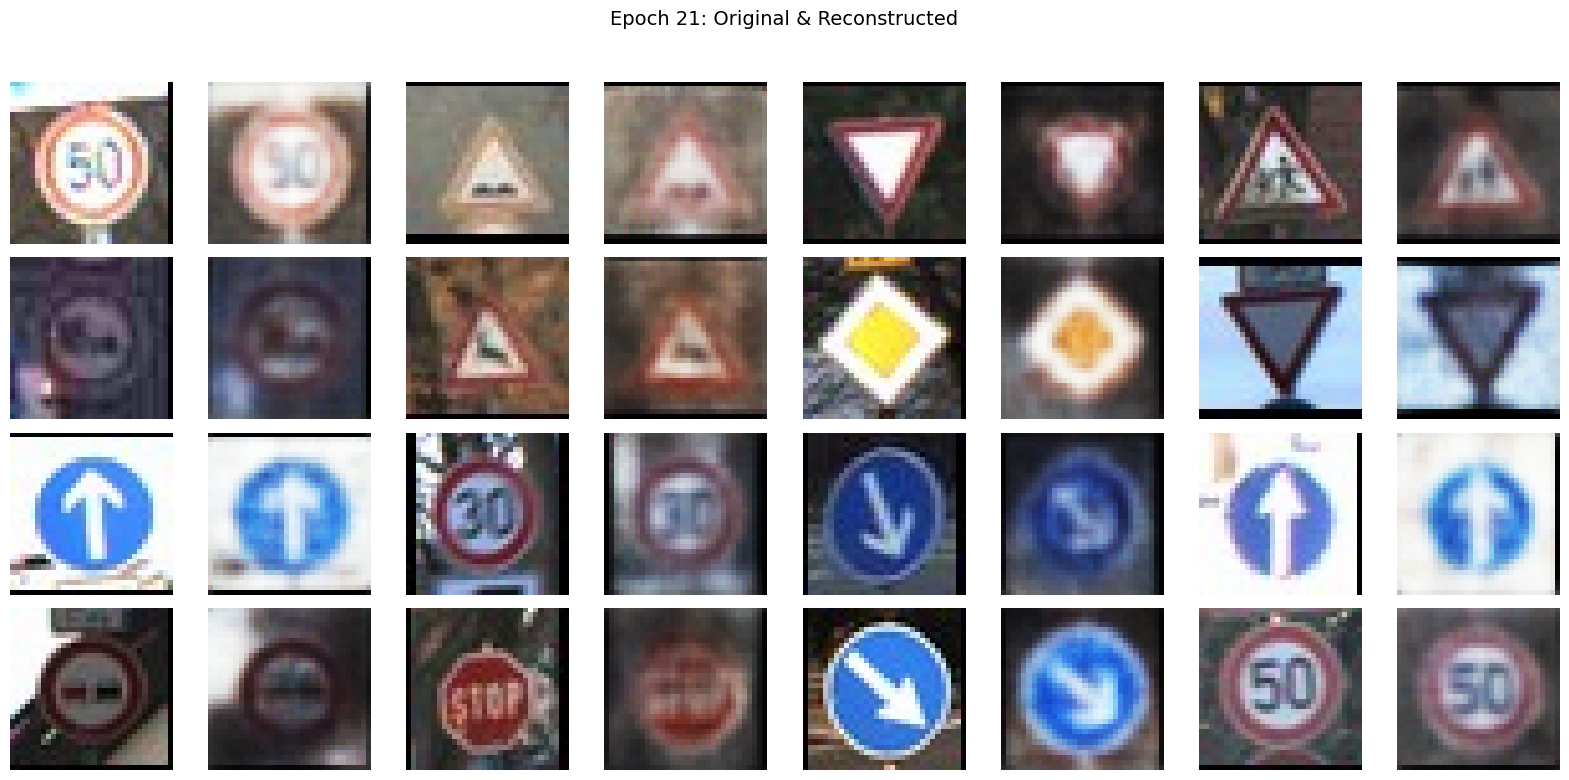

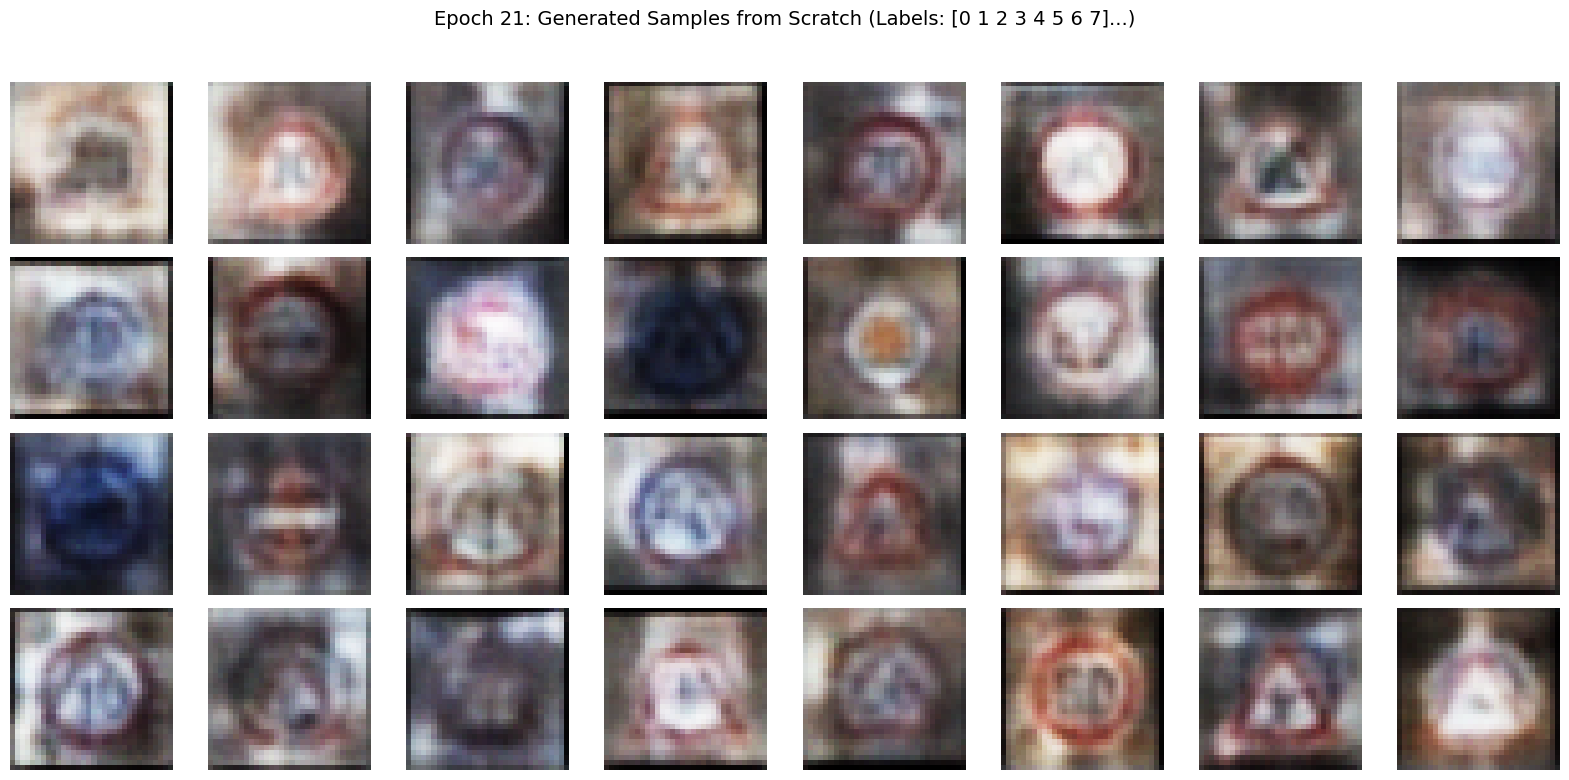

Epoch 22/100: 100%|██████████| 246/246 [00:19<00:00, 12.83it/s]


Epoch 22/100: Total Loss: 181.9447, Recon Loss: 132.6086, KLD Loss: 49.3362


Epoch 23/100: 100%|██████████| 246/246 [00:22<00:00, 10.73it/s]


Epoch 23/100: Total Loss: 180.4923, Recon Loss: 130.9135, KLD Loss: 49.5788


Epoch 24/100: 100%|██████████| 246/246 [00:22<00:00, 11.06it/s]


Epoch 24/100: Total Loss: 178.9524, Recon Loss: 129.2411, KLD Loss: 49.7113


Epoch 25/100: 100%|██████████| 246/246 [00:18<00:00, 13.39it/s]


Epoch 25/100: Total Loss: 177.5961, Recon Loss: 127.8710, KLD Loss: 49.7250


Epoch 26/100: 100%|██████████| 246/246 [00:21<00:00, 11.20it/s]


Epoch 26/100: Total Loss: 176.2459, Recon Loss: 126.4581, KLD Loss: 49.7877


Epoch 27/100: 100%|██████████| 246/246 [00:18<00:00, 13.24it/s]


Epoch 27/100: Total Loss: 175.2035, Recon Loss: 125.1820, KLD Loss: 50.0216


Epoch 28/100: 100%|██████████| 246/246 [00:22<00:00, 11.16it/s]


Epoch 28/100: Total Loss: 174.0351, Recon Loss: 123.9613, KLD Loss: 50.0738


Epoch 29/100: 100%|██████████| 246/246 [00:18<00:00, 13.41it/s]


Epoch 29/100: Total Loss: 172.9996, Recon Loss: 122.8081, KLD Loss: 50.1915


Epoch 30/100: 100%|██████████| 246/246 [00:22<00:00, 11.15it/s]


Epoch 30/100: Total Loss: 172.0605, Recon Loss: 121.9010, KLD Loss: 50.1595


Epoch 31/100: 100%|██████████| 246/246 [00:22<00:00, 11.03it/s]


Epoch 31/100: Total Loss: 171.1209, Recon Loss: 120.8759, KLD Loss: 50.2450


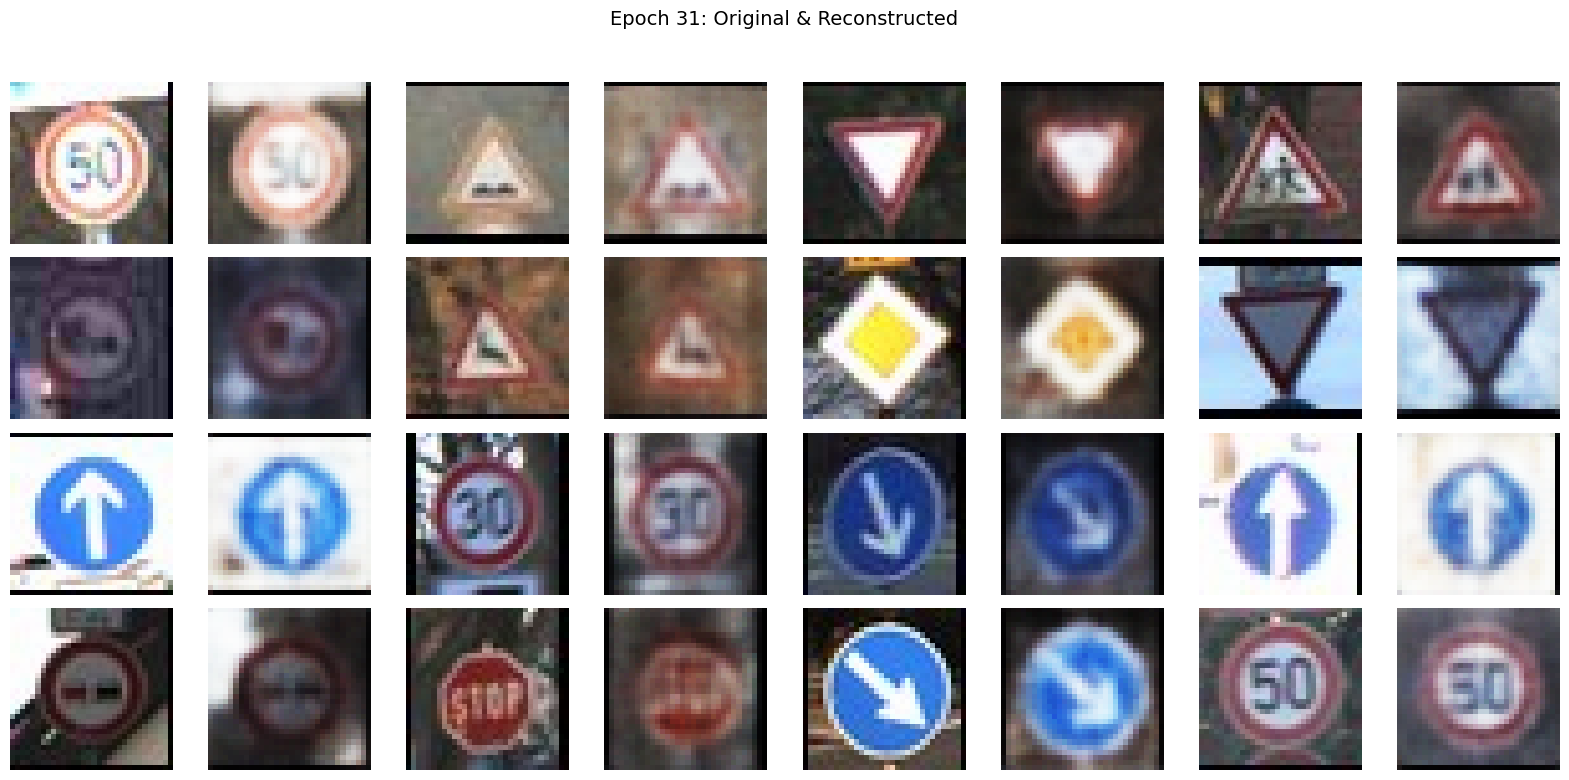

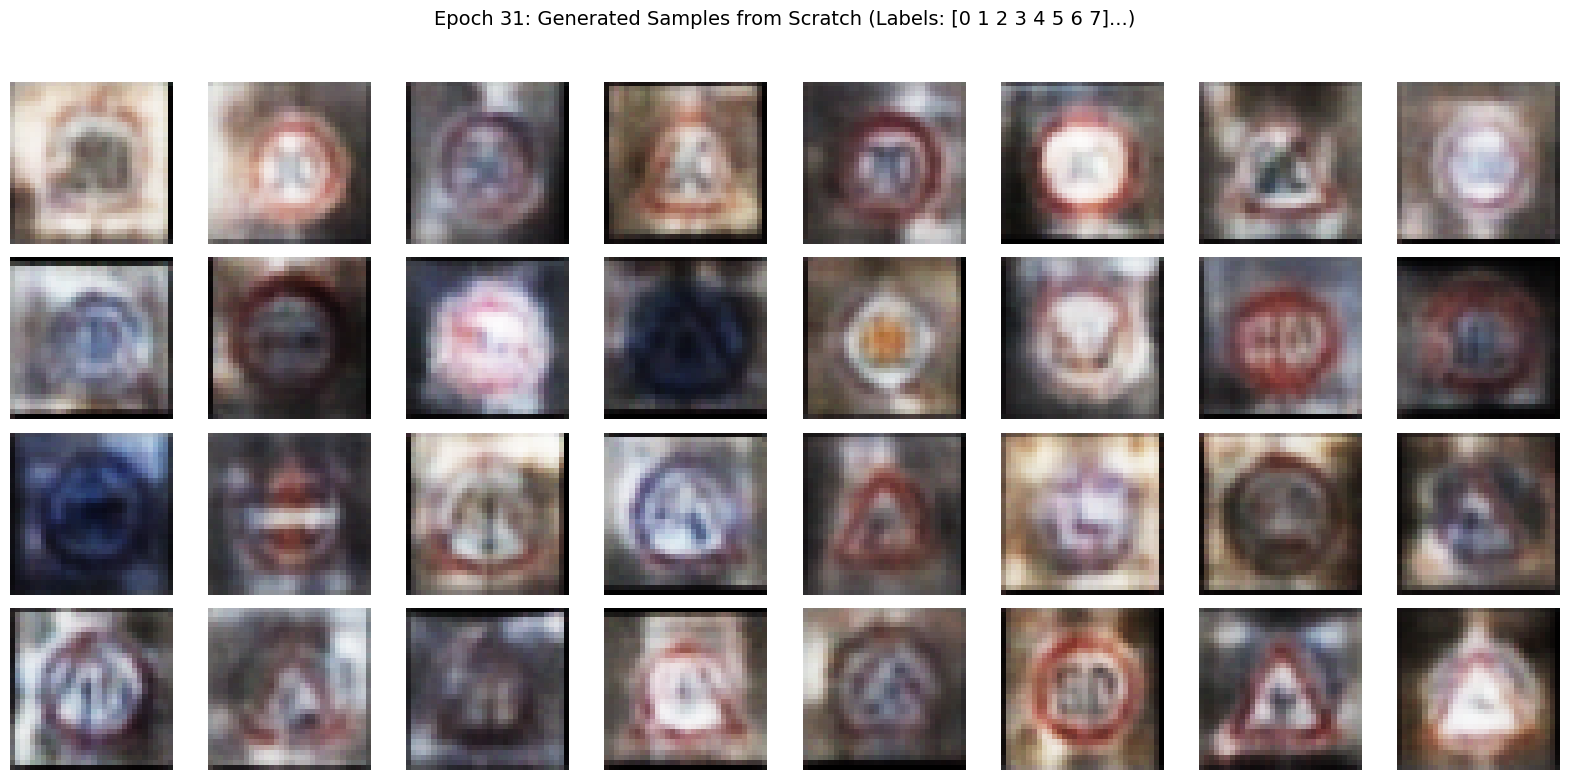

Epoch 32/100: 100%|██████████| 246/246 [00:17<00:00, 13.69it/s]


Epoch 32/100: Total Loss: 170.4049, Recon Loss: 120.0078, KLD Loss: 50.3971


Epoch 33/100: 100%|██████████| 246/246 [00:21<00:00, 11.23it/s]


Epoch 33/100: Total Loss: 169.4431, Recon Loss: 119.0913, KLD Loss: 50.3517


Epoch 34/100: 100%|██████████| 246/246 [00:18<00:00, 13.34it/s]


Epoch 34/100: Total Loss: 168.7405, Recon Loss: 118.3353, KLD Loss: 50.4052


Epoch 35/100: 100%|██████████| 246/246 [00:22<00:00, 10.85it/s]


Epoch 35/100: Total Loss: 167.8597, Recon Loss: 117.3575, KLD Loss: 50.5022


Epoch 36/100: 100%|██████████| 246/246 [00:18<00:00, 13.37it/s]


Epoch 36/100: Total Loss: 167.3272, Recon Loss: 116.8343, KLD Loss: 50.4929


Epoch 37/100: 100%|██████████| 246/246 [00:20<00:00, 11.72it/s]


Epoch 37/100: Total Loss: 166.6390, Recon Loss: 116.0955, KLD Loss: 50.5435


Epoch 38/100: 100%|██████████| 246/246 [00:22<00:00, 10.98it/s]


Epoch 38/100: Total Loss: 165.8731, Recon Loss: 115.3380, KLD Loss: 50.5352


Epoch 39/100: 100%|██████████| 246/246 [00:18<00:00, 13.16it/s]


Epoch 39/100: Total Loss: 165.2856, Recon Loss: 114.7615, KLD Loss: 50.5241


Epoch 40/100: 100%|██████████| 246/246 [00:21<00:00, 11.55it/s]


Epoch 40/100: Total Loss: 164.8298, Recon Loss: 114.2661, KLD Loss: 50.5636


Epoch 41/100: 100%|██████████| 246/246 [00:18<00:00, 13.25it/s]


Epoch 41/100: Total Loss: 164.1418, Recon Loss: 113.5216, KLD Loss: 50.6202


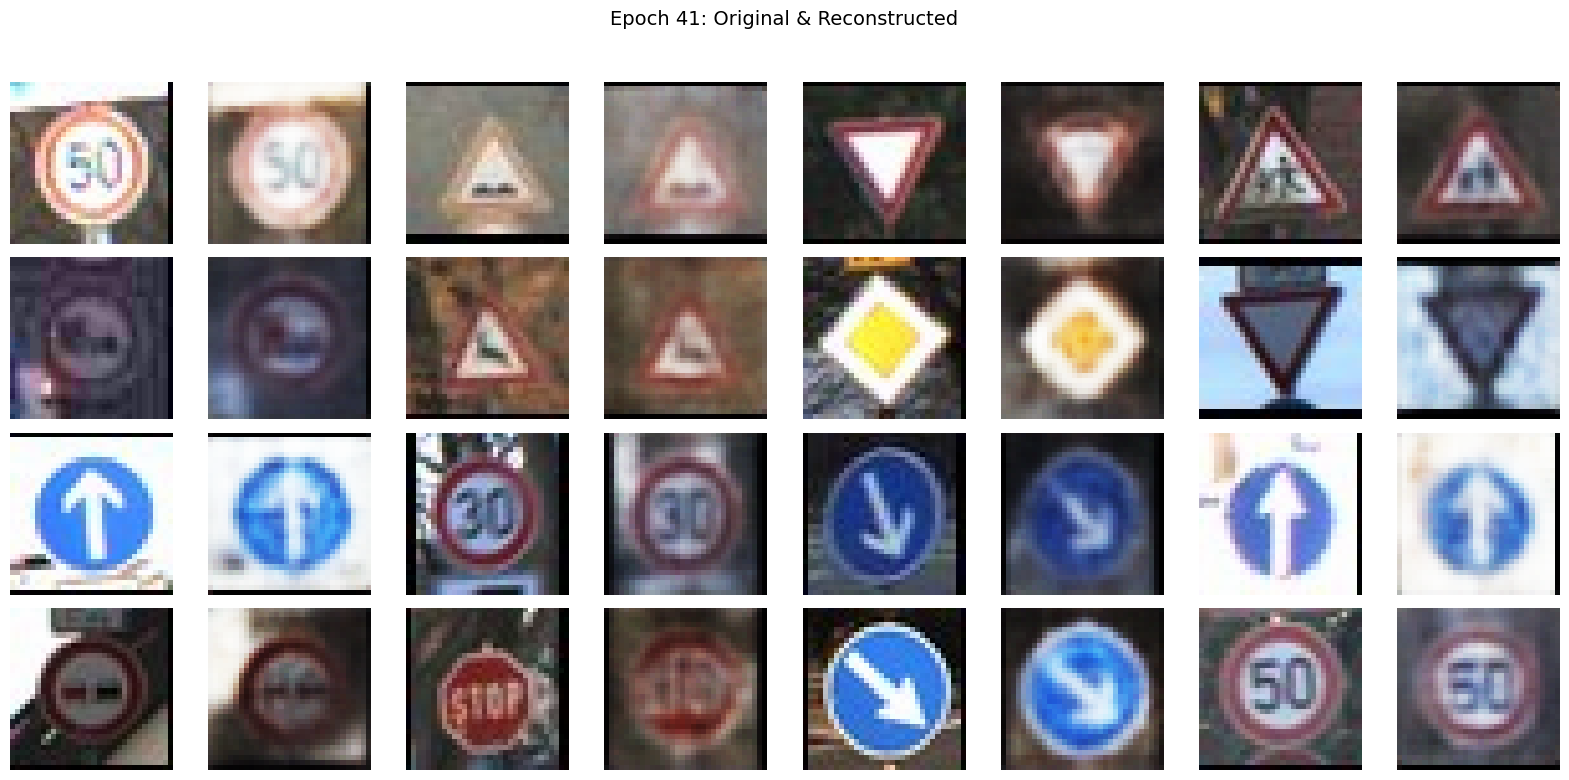

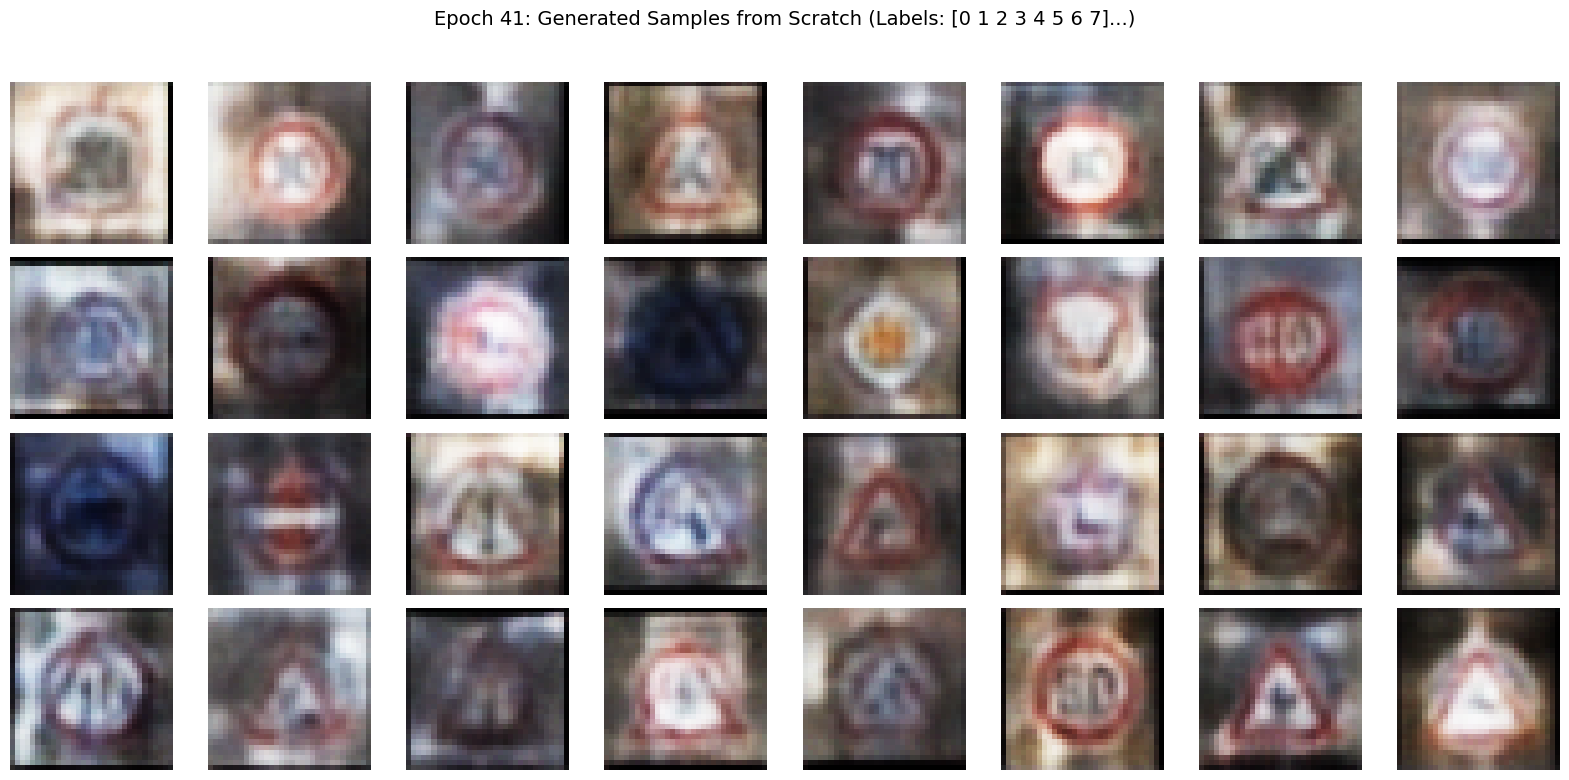

Epoch 42/100: 100%|██████████| 246/246 [00:23<00:00, 10.68it/s]


Epoch 42/100: Total Loss: 163.9680, Recon Loss: 113.2411, KLD Loss: 50.7268


Epoch 43/100: 100%|██████████| 246/246 [00:22<00:00, 11.03it/s]


Epoch 43/100: Total Loss: 163.2428, Recon Loss: 112.5429, KLD Loss: 50.6999


Epoch 44/100: 100%|██████████| 246/246 [00:18<00:00, 13.10it/s]


Epoch 44/100: Total Loss: 162.9051, Recon Loss: 112.1874, KLD Loss: 50.7177


Epoch 45/100: 100%|██████████| 246/246 [00:21<00:00, 11.24it/s]


Epoch 45/100: Total Loss: 162.2029, Recon Loss: 111.5086, KLD Loss: 50.6943


Epoch 46/100: 100%|██████████| 246/246 [00:19<00:00, 12.86it/s]


Epoch 46/100: Total Loss: 161.6671, Recon Loss: 110.9705, KLD Loss: 50.6966


Epoch 47/100: 100%|██████████| 246/246 [00:23<00:00, 10.69it/s]


Epoch 47/100: Total Loss: 161.3919, Recon Loss: 110.6936, KLD Loss: 50.6983


Epoch 48/100: 100%|██████████| 246/246 [00:22<00:00, 10.87it/s]


Epoch 48/100: Total Loss: 160.8071, Recon Loss: 110.0849, KLD Loss: 50.7221


Epoch 49/100: 100%|██████████| 246/246 [00:19<00:00, 12.80it/s]


Epoch 49/100: Total Loss: 160.5170, Recon Loss: 109.8299, KLD Loss: 50.6871


Epoch 50/100: 100%|██████████| 246/246 [00:23<00:00, 10.62it/s]


Epoch 50/100: Total Loss: 160.2278, Recon Loss: 109.4979, KLD Loss: 50.7299


Epoch 51/100: 100%|██████████| 246/246 [00:19<00:00, 12.51it/s]


Epoch 51/100: Total Loss: 159.5458, Recon Loss: 108.8374, KLD Loss: 50.7084


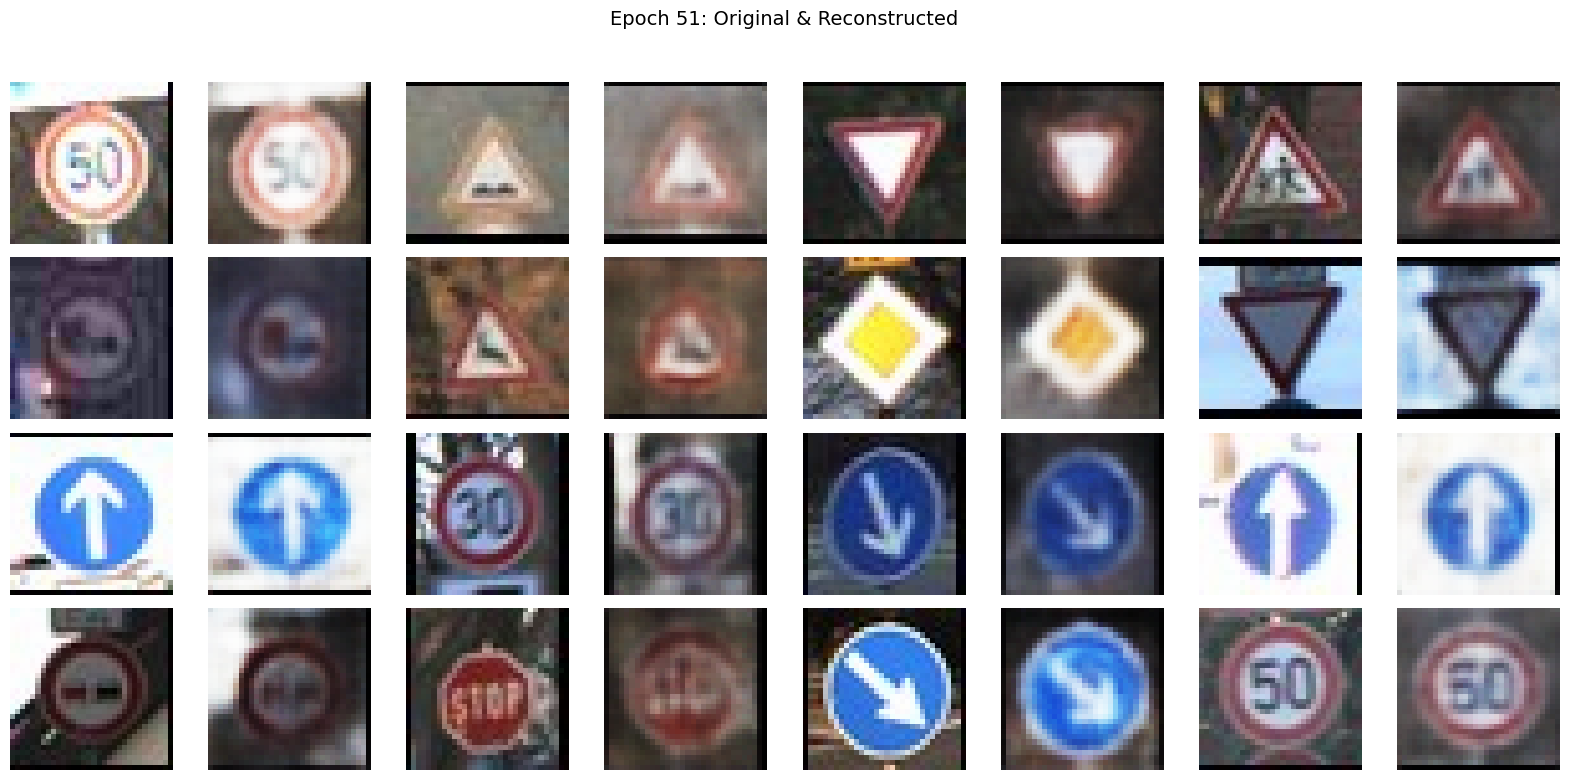

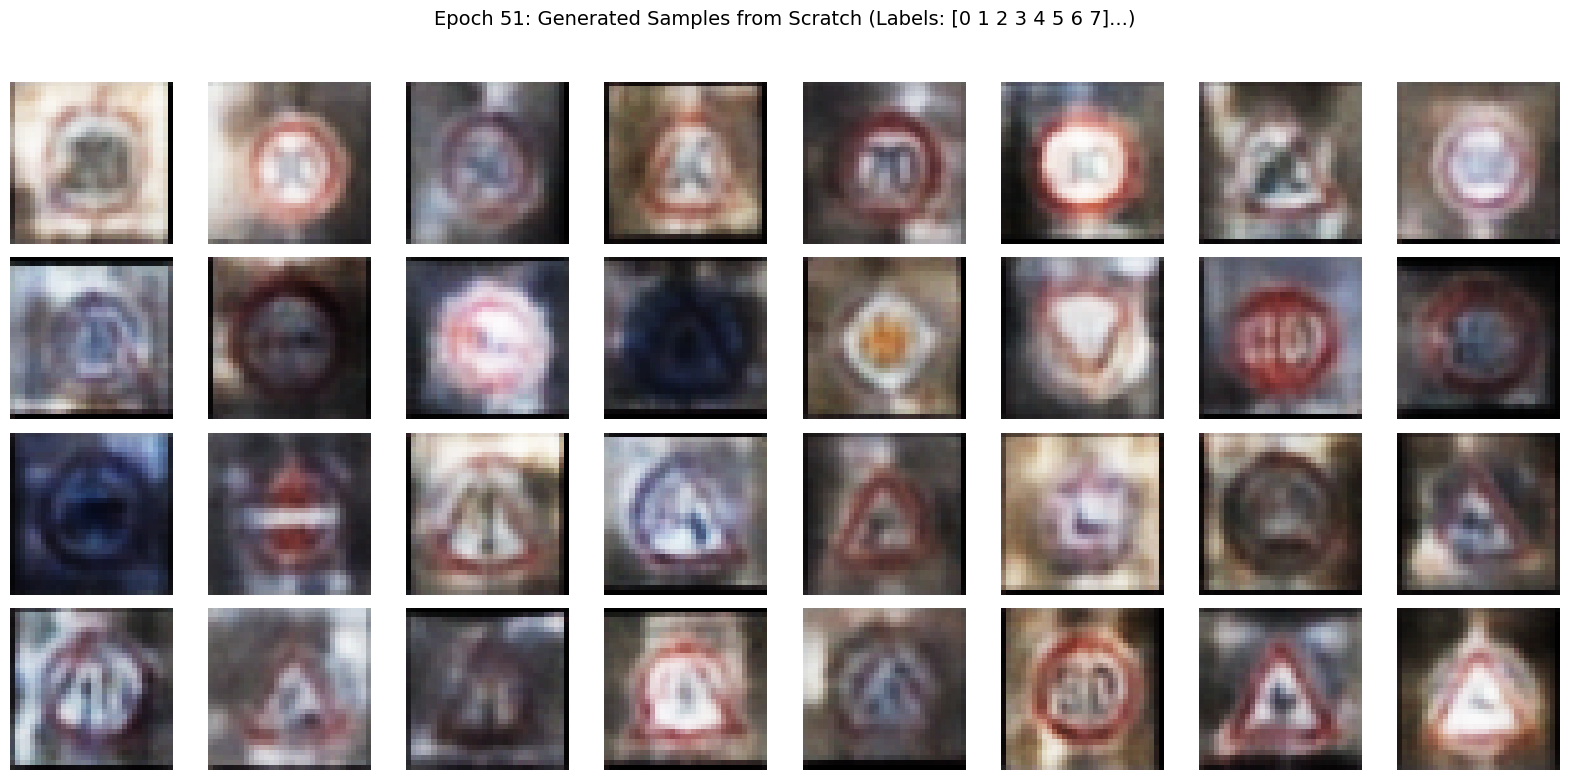

Epoch 52/100: 100%|██████████| 246/246 [00:23<00:00, 10.62it/s]


Epoch 52/100: Total Loss: 159.3889, Recon Loss: 108.6871, KLD Loss: 50.7018


Epoch 53/100: 100%|██████████| 246/246 [00:22<00:00, 10.79it/s]


Epoch 53/100: Total Loss: 159.1129, Recon Loss: 108.3664, KLD Loss: 50.7465


Epoch 54/100: 100%|██████████| 246/246 [00:18<00:00, 13.13it/s]


Epoch 54/100: Total Loss: 158.8140, Recon Loss: 108.0363, KLD Loss: 50.7778


Epoch 55/100: 100%|██████████| 246/246 [00:22<00:00, 11.18it/s]


Epoch 55/100: Total Loss: 158.2128, Recon Loss: 107.4925, KLD Loss: 50.7203


Epoch 56/100: 100%|██████████| 246/246 [00:18<00:00, 13.25it/s]


Epoch 56/100: Total Loss: 158.0913, Recon Loss: 107.3757, KLD Loss: 50.7156


Epoch 57/100: 100%|██████████| 246/246 [00:21<00:00, 11.24it/s]


Epoch 57/100: Total Loss: 157.7031, Recon Loss: 106.9552, KLD Loss: 50.7479


Epoch 58/100: 100%|██████████| 246/246 [00:22<00:00, 11.17it/s]


Epoch 58/100: Total Loss: 157.4243, Recon Loss: 106.7207, KLD Loss: 50.7036


Epoch 59/100: 100%|██████████| 246/246 [00:18<00:00, 13.06it/s]


Epoch 59/100: Total Loss: 157.1613, Recon Loss: 106.4040, KLD Loss: 50.7573


Epoch 60/100: 100%|██████████| 246/246 [00:22<00:00, 10.97it/s]


Epoch 60/100: Total Loss: 156.7874, Recon Loss: 106.0800, KLD Loss: 50.7074


Epoch 61/100: 100%|██████████| 246/246 [00:21<00:00, 11.30it/s]


Epoch 61/100: Total Loss: 156.5560, Recon Loss: 105.8437, KLD Loss: 50.7123


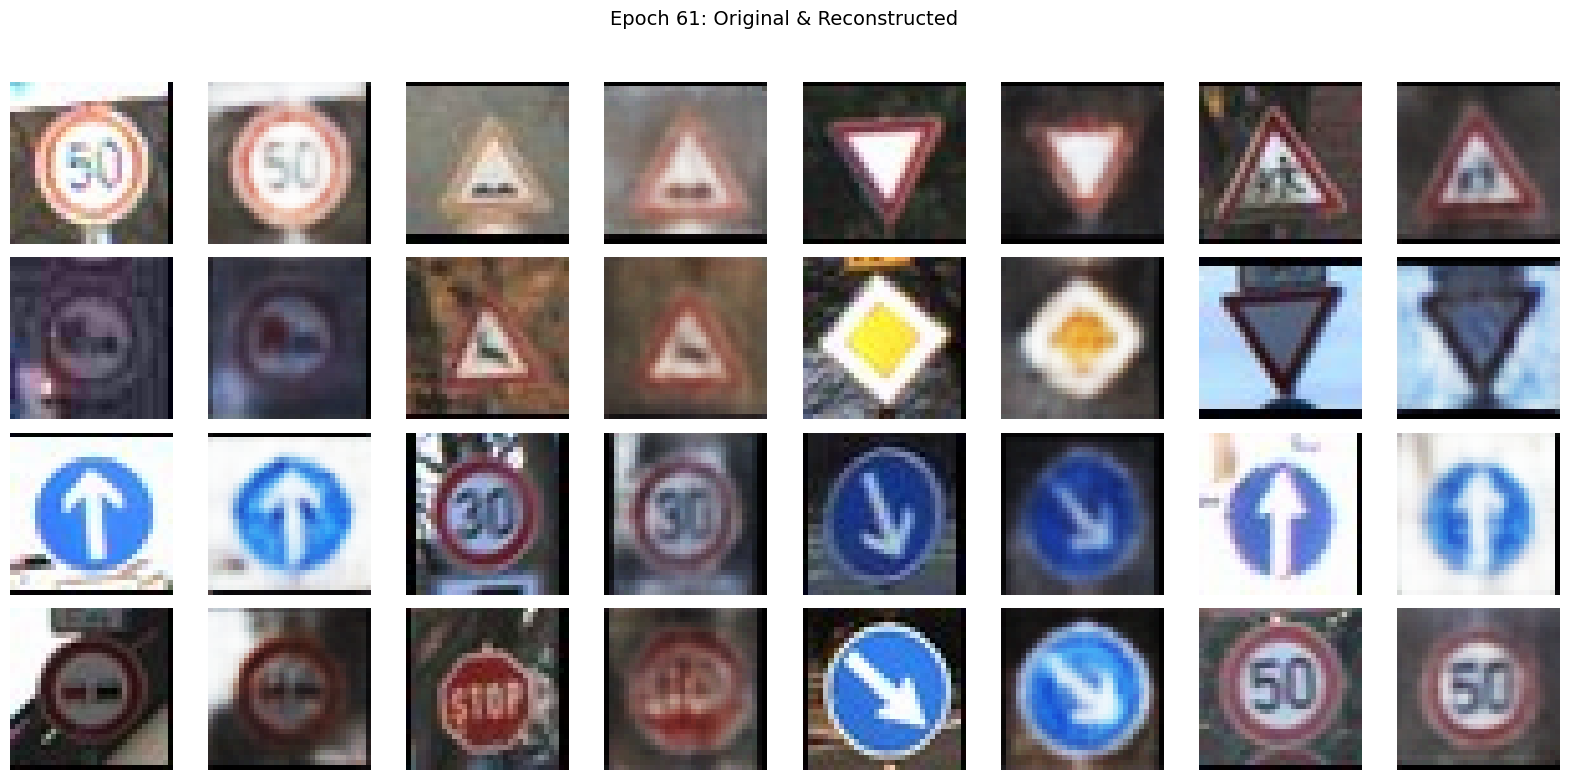

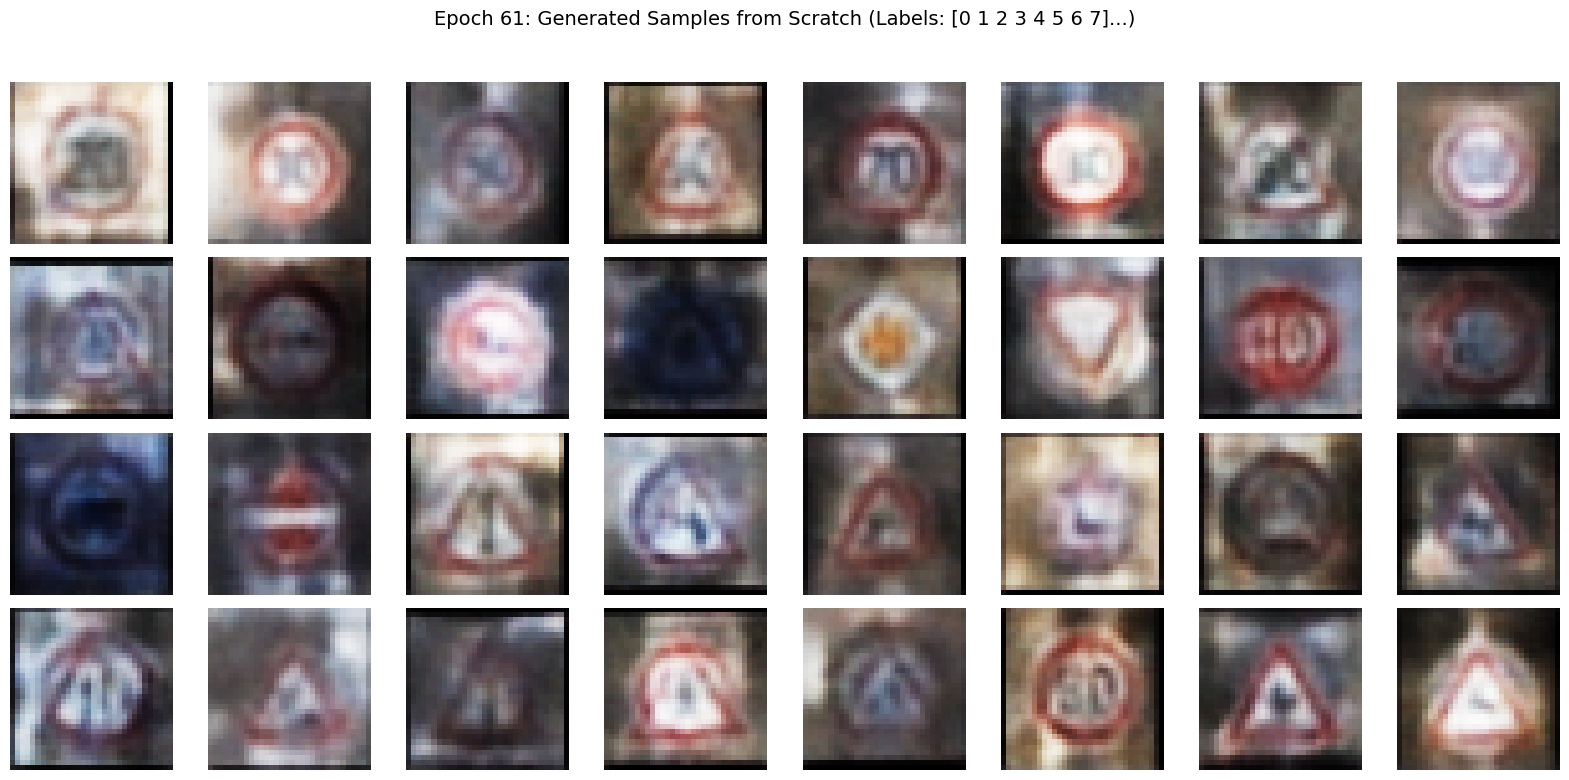

Epoch 62/100: 100%|██████████| 246/246 [00:19<00:00, 12.49it/s]


Epoch 62/100: Total Loss: 156.3029, Recon Loss: 105.5463, KLD Loss: 50.7566


Epoch 63/100: 100%|██████████| 246/246 [00:21<00:00, 11.32it/s]


Epoch 63/100: Total Loss: 155.9731, Recon Loss: 105.3144, KLD Loss: 50.6587


Epoch 64/100: 100%|██████████| 246/246 [00:19<00:00, 12.59it/s]


Epoch 64/100: Total Loss: 155.9761, Recon Loss: 105.2670, KLD Loss: 50.7092


Epoch 65/100: 100%|██████████| 246/246 [00:20<00:00, 11.85it/s]


Epoch 65/100: Total Loss: 155.5171, Recon Loss: 104.8500, KLD Loss: 50.6671


Epoch 66/100: 100%|██████████| 246/246 [00:21<00:00, 11.25it/s]


Epoch 66/100: Total Loss: 155.2155, Recon Loss: 104.5432, KLD Loss: 50.6723


Epoch 67/100: 100%|██████████| 246/246 [00:19<00:00, 12.60it/s]


Epoch 67/100: Total Loss: 154.9850, Recon Loss: 104.3439, KLD Loss: 50.6411


Epoch 68/100: 100%|██████████| 246/246 [00:21<00:00, 11.28it/s]


Epoch 68/100: Total Loss: 154.8778, Recon Loss: 104.1973, KLD Loss: 50.6805


Epoch 69/100: 100%|██████████| 246/246 [00:19<00:00, 12.91it/s]


Epoch 69/100: Total Loss: 154.6970, Recon Loss: 104.0393, KLD Loss: 50.6577


Epoch 70/100: 100%|██████████| 246/246 [00:21<00:00, 11.32it/s]


Epoch 70/100: Total Loss: 154.3841, Recon Loss: 103.7304, KLD Loss: 50.6538


Epoch 71/100: 100%|██████████| 246/246 [00:21<00:00, 11.37it/s]


Epoch 71/100: Total Loss: 154.3488, Recon Loss: 103.6082, KLD Loss: 50.7406


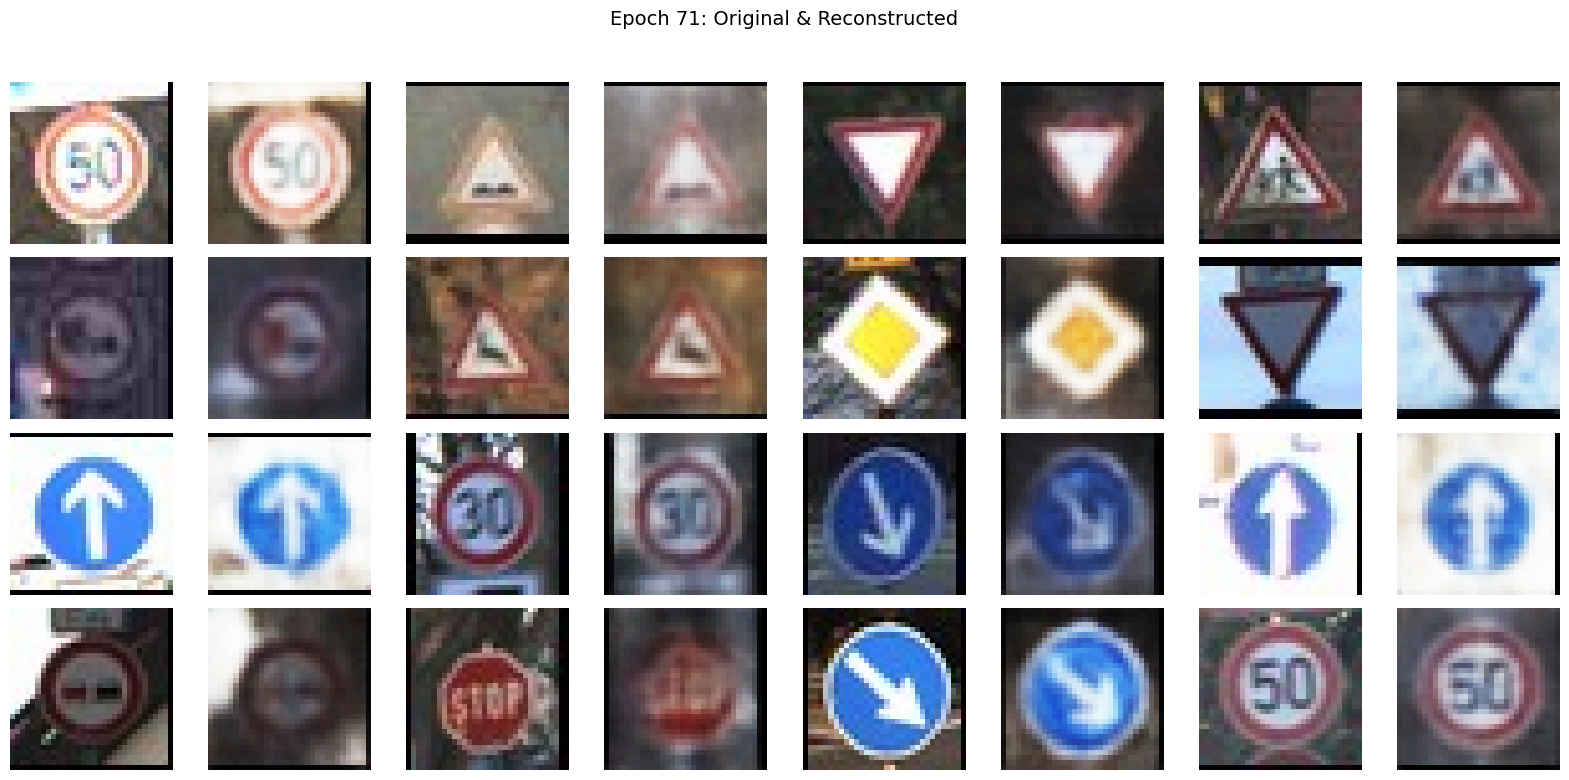

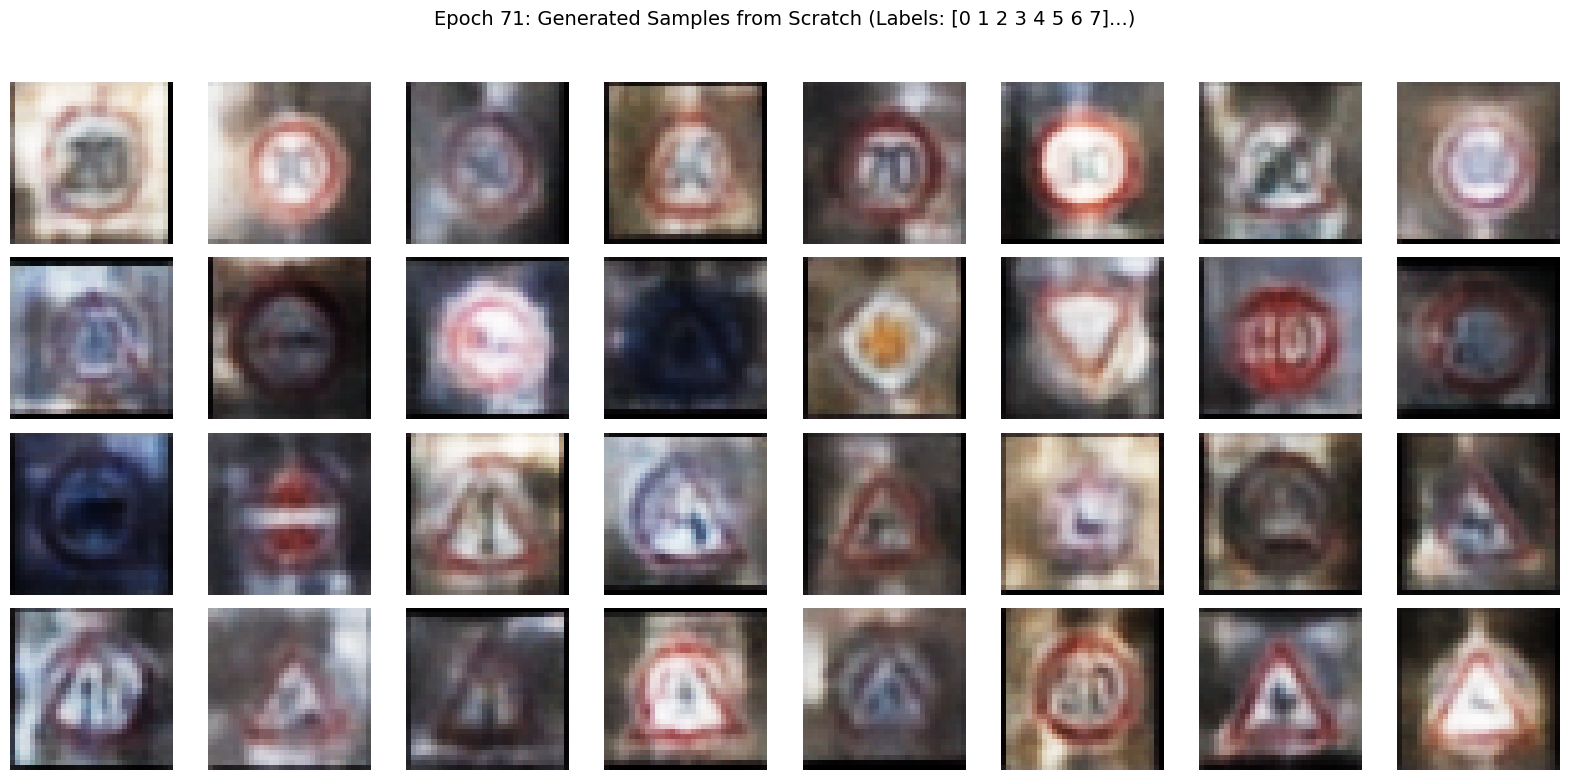

Epoch 72/100: 100%|██████████| 246/246 [00:19<00:00, 12.70it/s]


Epoch 72/100: Total Loss: 154.1052, Recon Loss: 103.4750, KLD Loss: 50.6301


Epoch 73/100: 100%|██████████| 246/246 [00:21<00:00, 11.50it/s]


Epoch 73/100: Total Loss: 153.6584, Recon Loss: 103.0561, KLD Loss: 50.6023


Epoch 74/100: 100%|██████████| 246/246 [00:19<00:00, 12.66it/s]


Epoch 74/100: Total Loss: 153.5173, Recon Loss: 102.8678, KLD Loss: 50.6495


Epoch 75/100: 100%|██████████| 246/246 [00:21<00:00, 11.53it/s]


Epoch 75/100: Total Loss: 153.3534, Recon Loss: 102.7278, KLD Loss: 50.6256


Epoch 76/100: 100%|██████████| 246/246 [00:22<00:00, 10.94it/s]


Epoch 76/100: Total Loss: 153.2310, Recon Loss: 102.6709, KLD Loss: 50.5601


Epoch 77/100: 100%|██████████| 246/246 [00:20<00:00, 12.22it/s]


Epoch 77/100: Total Loss: 152.8680, Recon Loss: 102.3080, KLD Loss: 50.5600


Epoch 78/100: 100%|██████████| 246/246 [00:21<00:00, 11.31it/s]


Epoch 78/100: Total Loss: 152.7018, Recon Loss: 102.1163, KLD Loss: 50.5854


Epoch 79/100: 100%|██████████| 246/246 [00:18<00:00, 13.16it/s]


Epoch 79/100: Total Loss: 152.6204, Recon Loss: 102.0478, KLD Loss: 50.5726


Epoch 80/100: 100%|██████████| 246/246 [00:21<00:00, 11.41it/s]


Epoch 80/100: Total Loss: 152.2986, Recon Loss: 101.8423, KLD Loss: 50.4563


Epoch 81/100: 100%|██████████| 246/246 [00:21<00:00, 11.49it/s]


Epoch 81/100: Total Loss: 152.1942, Recon Loss: 101.6497, KLD Loss: 50.5445


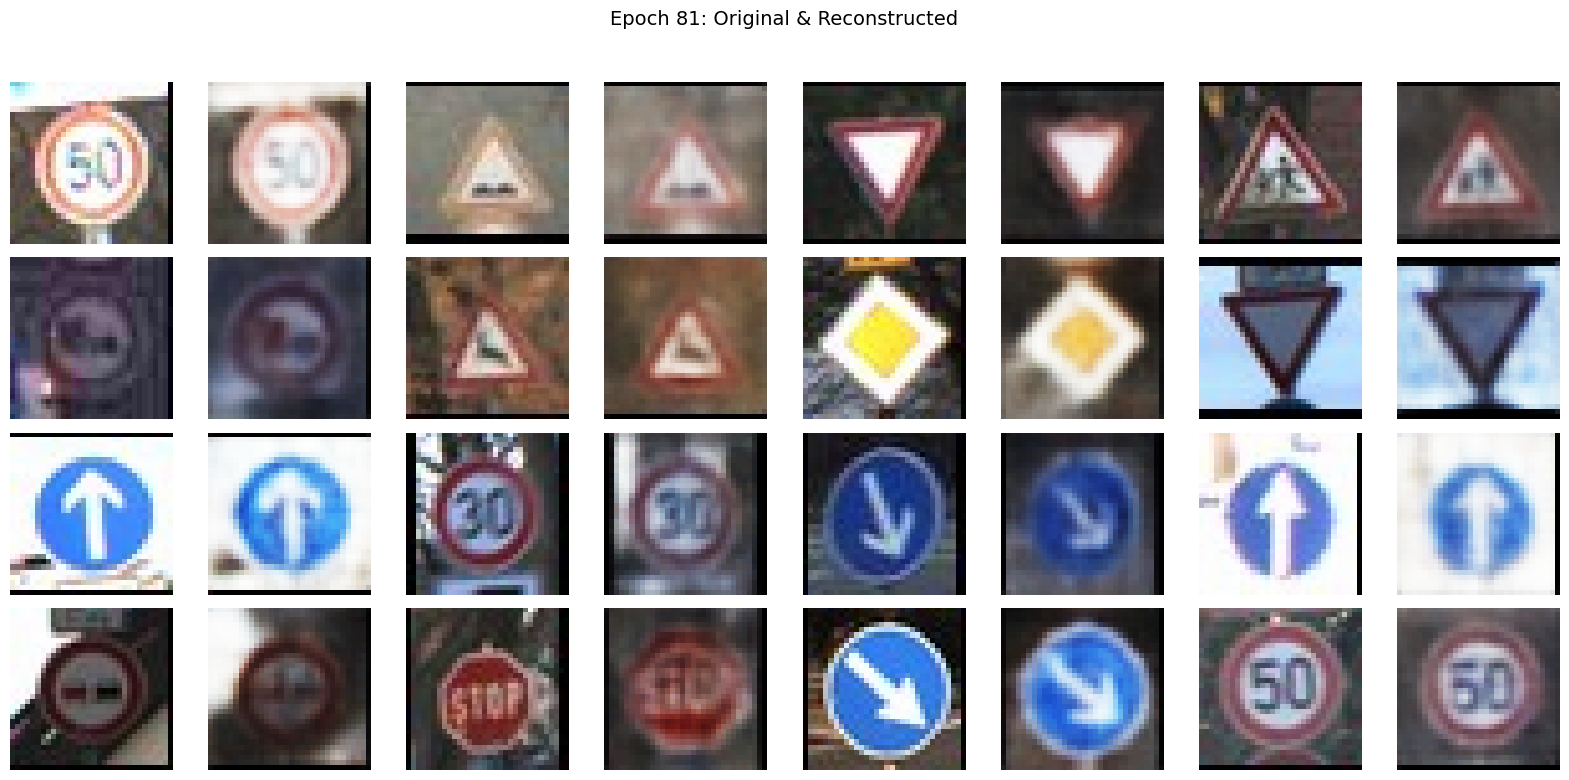

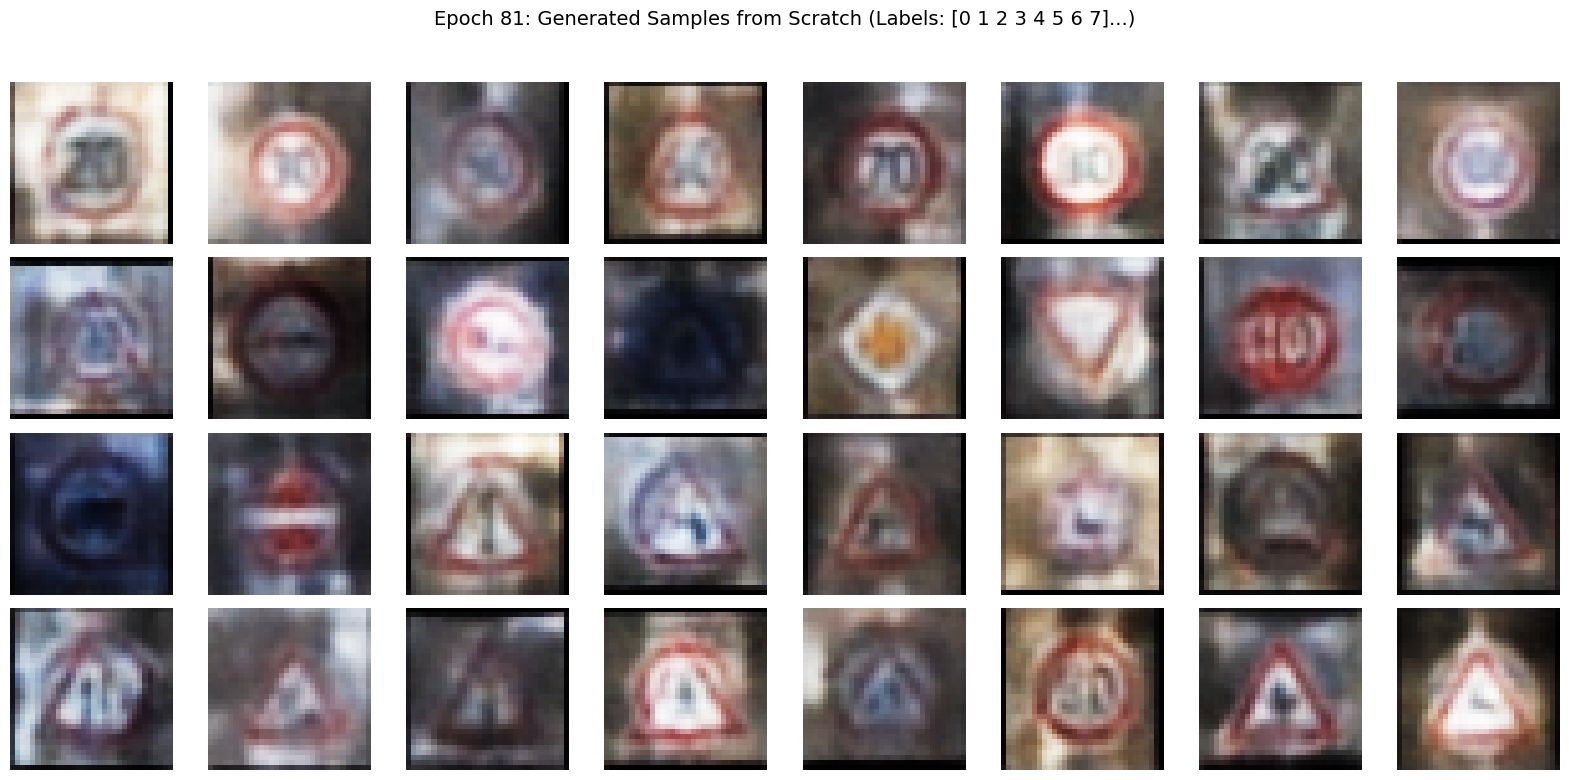

Epoch 82/100: 100%|██████████| 246/246 [00:22<00:00, 11.17it/s]


Epoch 82/100: Total Loss: 152.0025, Recon Loss: 101.5279, KLD Loss: 50.4746


Epoch 83/100: 100%|██████████| 246/246 [00:25<00:00,  9.51it/s]


Epoch 83/100: Total Loss: 152.0485, Recon Loss: 101.5211, KLD Loss: 50.5274


Epoch 84/100: 100%|██████████| 246/246 [00:21<00:00, 11.50it/s]


Epoch 84/100: Total Loss: 151.8828, Recon Loss: 101.3758, KLD Loss: 50.5069


Epoch 85/100: 100%|██████████| 246/246 [00:19<00:00, 12.54it/s]


Epoch 85/100: Total Loss: 151.6766, Recon Loss: 101.1737, KLD Loss: 50.5029


Epoch 86/100: 100%|██████████| 246/246 [00:22<00:00, 11.00it/s]


Epoch 86/100: Total Loss: 151.3556, Recon Loss: 100.8979, KLD Loss: 50.4577


Epoch 87/100: 100%|██████████| 246/246 [00:18<00:00, 13.27it/s]


Epoch 87/100: Total Loss: 151.2909, Recon Loss: 100.8106, KLD Loss: 50.4803


Epoch 88/100: 100%|██████████| 246/246 [00:21<00:00, 11.62it/s]


Epoch 88/100: Total Loss: 151.1096, Recon Loss: 100.6979, KLD Loss: 50.4116


Epoch 89/100: 100%|██████████| 246/246 [00:20<00:00, 11.90it/s]


Epoch 89/100: Total Loss: 151.1322, Recon Loss: 100.5958, KLD Loss: 50.5364


Epoch 90/100: 100%|██████████| 246/246 [00:18<00:00, 13.53it/s]


Epoch 90/100: Total Loss: 150.8524, Recon Loss: 100.4633, KLD Loss: 50.3891


Epoch 91/100: 100%|██████████| 246/246 [00:20<00:00, 11.85it/s]


Epoch 91/100: Total Loss: 150.7745, Recon Loss: 100.3290, KLD Loss: 50.4455


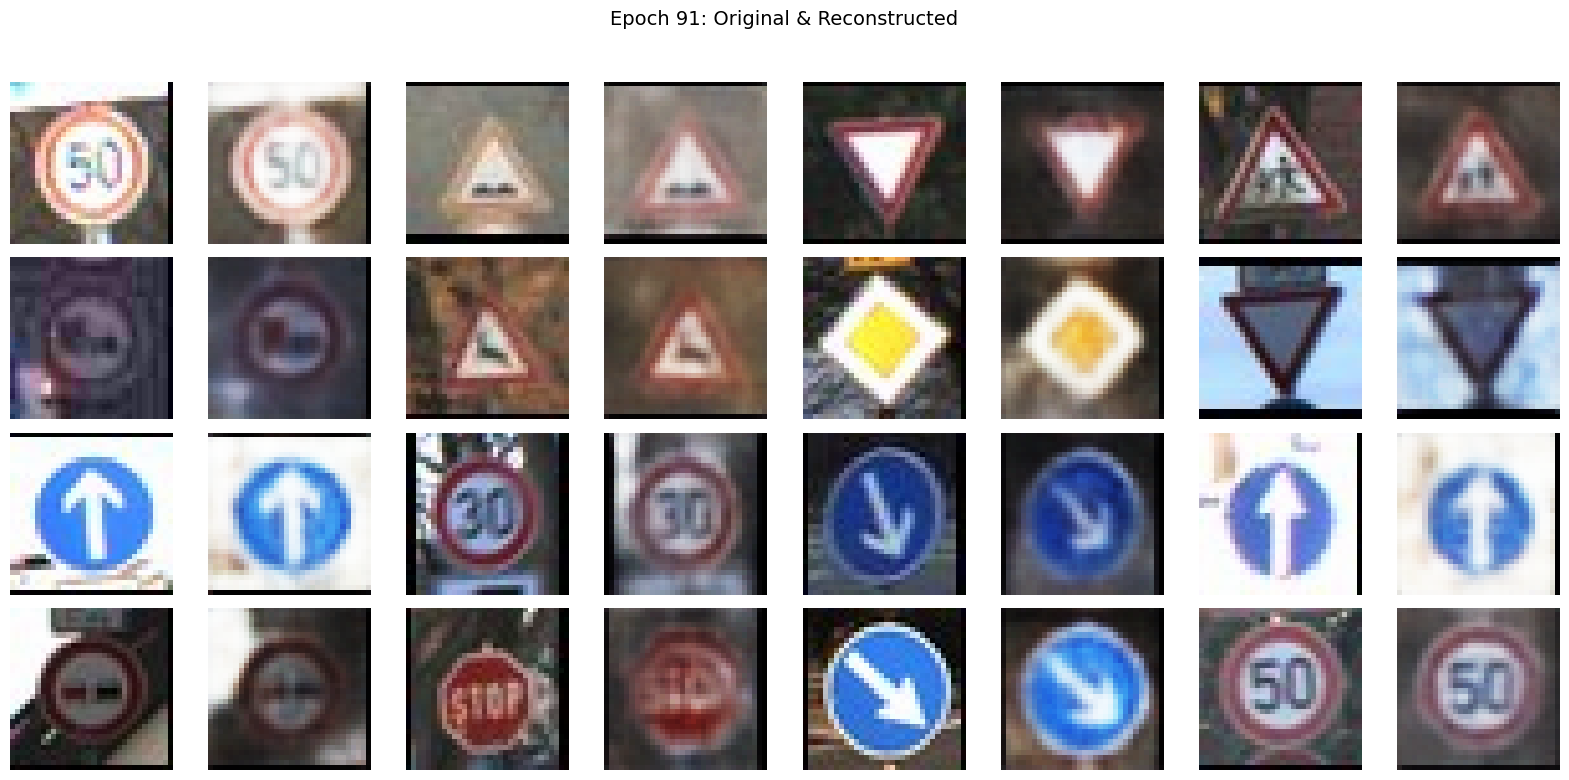

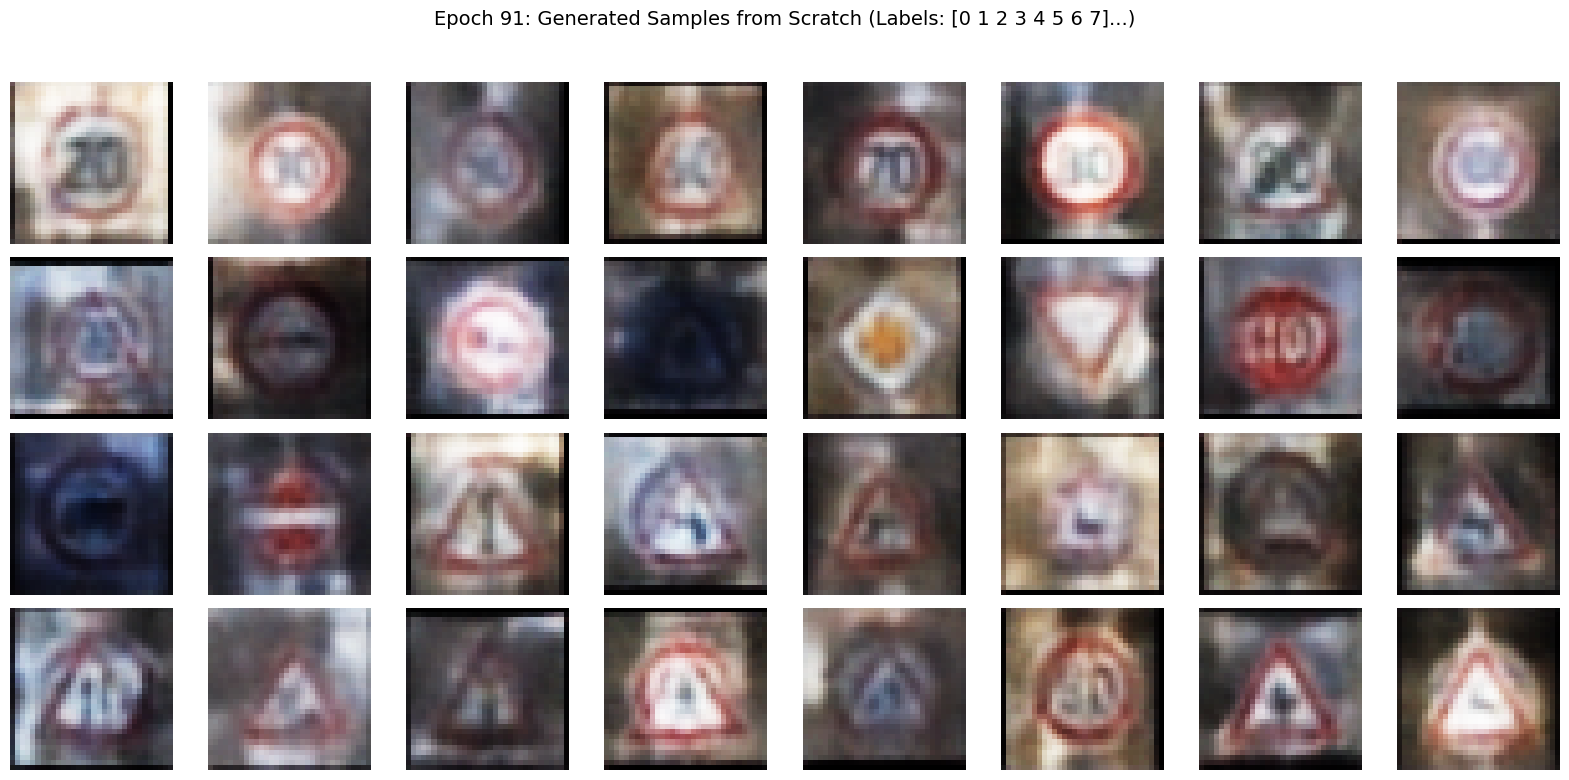

Epoch 92/100: 100%|██████████| 246/246 [00:19<00:00, 12.85it/s]


Epoch 92/100: Total Loss: 150.6943, Recon Loss: 100.2833, KLD Loss: 50.4111


Epoch 93/100: 100%|██████████| 246/246 [00:21<00:00, 11.44it/s]


Epoch 93/100: Total Loss: 150.4719, Recon Loss: 100.0104, KLD Loss: 50.4615


Epoch 94/100: 100%|██████████| 246/246 [00:22<00:00, 11.15it/s]


Epoch 94/100: Total Loss: 150.2713, Recon Loss: 99.8982, KLD Loss: 50.3730


Epoch 95/100: 100%|██████████| 246/246 [00:18<00:00, 13.05it/s]


Epoch 95/100: Total Loss: 150.0505, Recon Loss: 99.7245, KLD Loss: 50.3260


Epoch 96/100: 100%|██████████| 246/246 [00:21<00:00, 11.62it/s]


Epoch 96/100: Total Loss: 150.0356, Recon Loss: 99.6528, KLD Loss: 50.3828


Epoch 97/100: 100%|██████████| 246/246 [00:19<00:00, 12.83it/s]


Epoch 97/100: Total Loss: 150.0059, Recon Loss: 99.7036, KLD Loss: 50.3023


Epoch 98/100: 100%|██████████| 246/246 [00:21<00:00, 11.59it/s]


Epoch 98/100: Total Loss: 149.7742, Recon Loss: 99.4525, KLD Loss: 50.3216


Epoch 99/100: 100%|██████████| 246/246 [00:20<00:00, 12.01it/s]


Epoch 99/100: Total Loss: 149.7777, Recon Loss: 99.4626, KLD Loss: 50.3151


Epoch 100/100: 100%|██████████| 246/246 [00:19<00:00, 12.67it/s]


Epoch 100/100: Total Loss: 149.4896, Recon Loss: 99.1691, KLD Loss: 50.3205


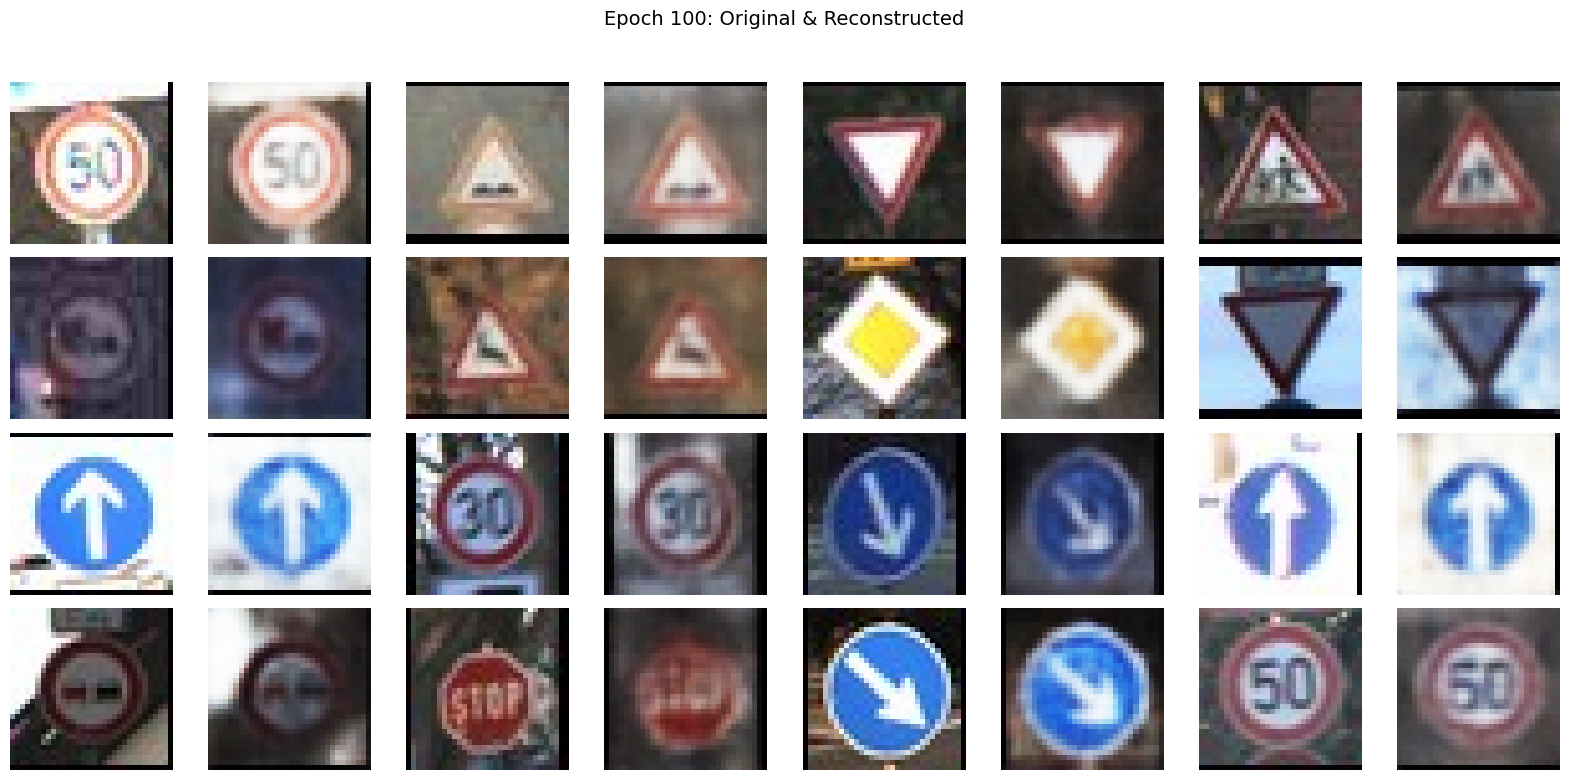

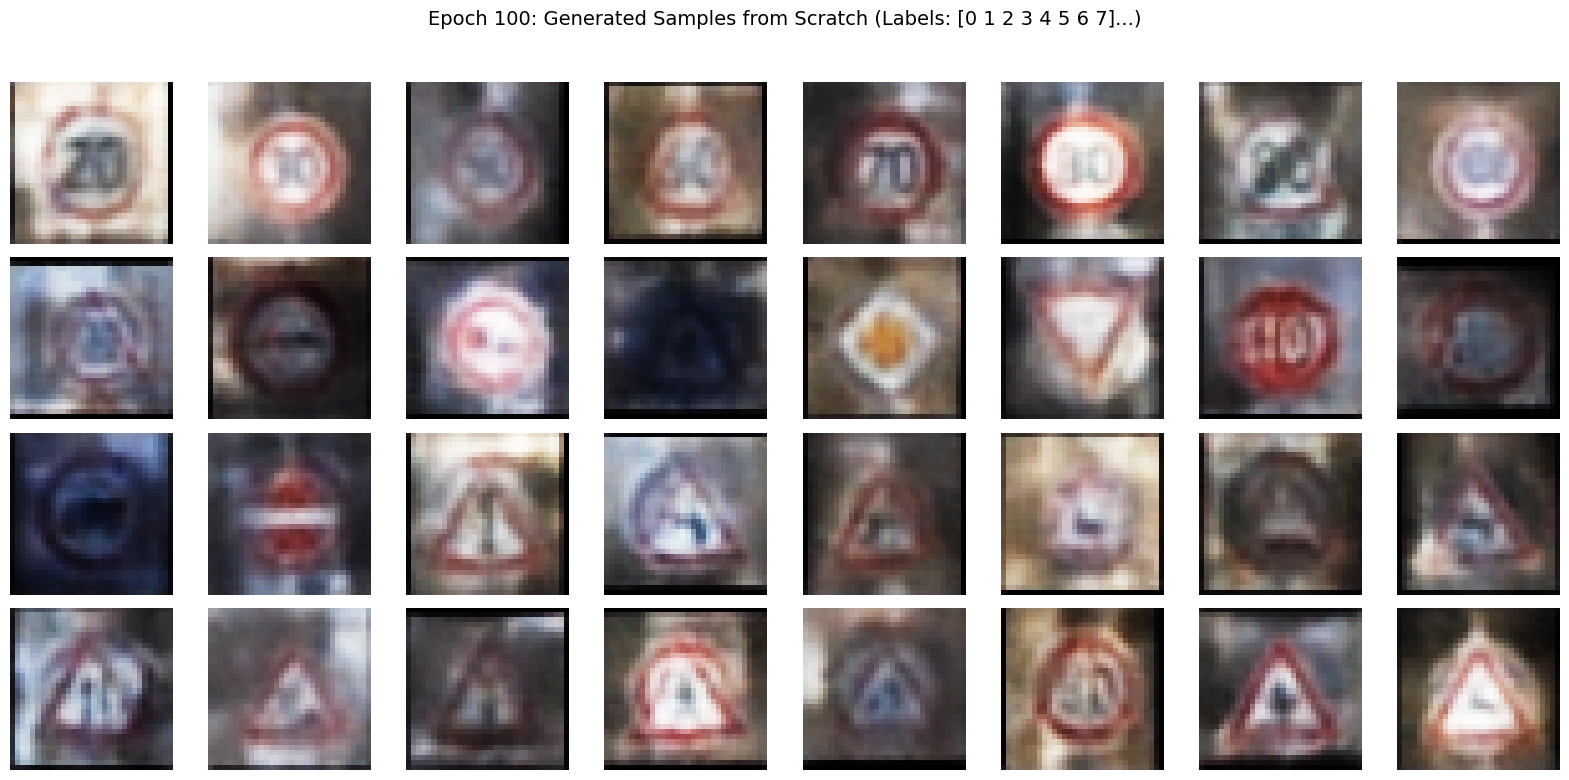

{'total_losses': [721.4501948162792,
  416.4215942630923,
  351.95850254462016,
  308.19055907706905,
  279.32615543768657,
  261.33191569258526,
  247.33045990486454,
  236.75193116723037,
  228.02222355788317,
  220.31008278451316,
  214.26206343736106,
  209.24535611780678,
  204.85838299262815,
  200.82958891333604,
  197.77592797007986,
  194.7156922255105,
  191.78205753729594,
  189.63573275930514,
  187.5353722300956,
  185.50158474309657,
  183.69816161365043,
  181.9447278898906,
  180.49232501518435,
  178.9523585249738,
  177.59605519364518,
  176.24587063673067,
  175.20353531255955,
  174.0351136990679,
  172.99958943933007,
  172.06047467487613,
  171.12090841153773,
  170.40489215385622,
  169.44305841709541,
  168.74049954298067,
  167.85968594434786,
  167.32716493684103,
  166.63896520351005,
  165.87314940661918,
  165.28555787869584,
  164.82978696745585,
  164.14179930648183,
  163.96796144314897,
  163.2428150332071,
  162.90506428044017,
  162.20291323778105,
  

In [108]:
cvae_trainer.fit(train_dl, num_epochs=100)

## Save model

In [109]:
import os
import torch

weights_dir = "./gnn/weights"

os.makedirs(weights_dir, exist_ok=True)

cvae_model_path = os.path.join(weights_dir, "cvae_model.pth")

torch.save(cvae_model.state_dict(), cvae_model_path)

print(f"cVAE model weights saved to: {cvae_model_path}")

cVAE model weights saved to: ./gnn/weights/cvae_model.pth


# Evaluation

## Load Dataset

In [110]:
test_dir = "./data/test"
test_ds = ImageFolder(test_dir)
len(test_ds), len(test_ds.classes)

(7842, 43)

In [112]:
import os
import time
from torchvision.utils import save_image
from collections import Counter


results_id = time.time()
results_dir = f"./cvae_results/{results_id}"
os.makedirs(results_dir, exist_ok=True)

mean_t = torch.tensor(train_mean).view(1, IMG_CHANNELS, 1, 1).to(device)
std_t = torch.tensor(train_std).view(1, IMG_CHANNELS, 1, 1).to(device)
class_counts = Counter(test_ds.targets)

vae_model.eval()



for cls, cnt in class_counts.items():
    for i in range(cnt):
        z = torch.randn(1, latent_dim, device=device)
        label_tensor = torch.tensor([cls], dtype=torch.long, device=device)

        with torch.no_grad():
            img = cvae_model.generate(z, label_tensor)

        img = img * std_t + mean_t

        fname = os.path.join(results_dir, f"class_{cls}_sample_{i}.jpg")
        save_image(img.clamp(0, 1), fname)
print(f"Saved generated images to {fname}")

Saved generated images to ./cvae_results/1747095047.4741828/class_42_sample_47.jpg


Calculate the FID between test set and generated images

In [113]:
from pytorch_fid.fid_score import calculate_fid_given_paths

test_flat_dir = "./data/test_flat"
generated_dir = results_dir

fid = calculate_fid_given_paths([test_flat_dir, generated_dir], batch_size, device, dims=2048, num_workers=1)

print(f"FID: {fid}")

100%|██████████| 62/62 [00:26<00:00,  2.31it/s]


FID: 120.71915894959778


In [ ]:
# clean up


# import shutil
# import os

# results_dir = f"./cvae_results/{results_id}"

# # Check if the directory exists before trying to remove it
# if os.path.exists(results_dir):
#     shutil.rmtree(results_dir)
#     print(f"Directory {results_dir}_{results_id} have been removed.")
# else:
#     print(f"The directory {results_dir}_{results_id} does not exist.")

Directory ./cvae_results/1747092739.8218522_1747092739.8218522 have been removed.
